In [5]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix

In [6]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 100     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
data = train_data_semeval.load_data("data/tsd_train.csv")
train_df_preprocessed = train_data_semeval.preprocess()

# extra_train = JigsawData(MAX_WORD_NUM)
# extra_train.load_data("data/train.csv")
# extra_train_df = extra_train.preprocess()

                                               spans  \
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...   
1                       [33, 34, 35, 36, 37, 38, 39]   
2                                       [0, 1, 2, 3]   
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]   
4                       [32, 33, 34, 35, 36, 37, 38]   
5                                                 []   
6  [39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...   
7                                       [0, 1, 2, 3]   
8  [49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...   
9                   [32, 33, 34, 35, 36, 37, 38, 39]   

                                                text  
0  Another violent and aggressive immigrant killi...  
1  I am 56 years old, I am not your fucking junio...  
2                  Damn, a whole family. Sad indeed.  
3  What a knucklehead. How can anyone not know th...  
4  "who do you think should do the killing?"\n\nA...  
5  But, but, but, is NOT a defense.  It's not eve... 

2 3
1 [[0, 3]]
spans       [7, 8, 9, 10, 11, 12, 135, 136, 137, 138, 139,...
text        What a coward.  Take your own but leave innoce...
toxicity                                                    1
Name: 49, dtype: object
[7, 8, 9, 10, 11, 12, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 153, 154, 155, 156]
7 8
8 9
9 10
10 11
11 12
12 135
135 136
136 137
137 138
138 139
139 140
140 142
142 143
143 144
144 145
145 146
146 153
153 154
154 155
155 156
4 [[7, 12], [135, 140], [142, 146], [153, 156]]
spans                                        [46, 47, 48, 49]
text        Not much, but caused a whole lot of  negative ...
toxicity                                                    1
Name: 50, dtype: object
[46, 47, 48, 49]
46 47
47 48
48 49
1 [[46, 49]]
spans                            [40, 41, 42, 43, 44, 45, 46]
text        Republicans have shown themselves to be idioti...
toxicity                                                    1
Name: 51, dtype: object
[40, 41, 42, 43, 4

1 [[161, 172]]
spans                      [19, 20, 21, 22]
text        As opposed to the "dumb meter"?
toxicity                                  1
Name: 109, dtype: object
[19, 20, 21, 22]
19 20
20 21
21 22
1 [[19, 22]]
spans       [312, 313, 314, 315, 316, 317, 318, 319, 320, ...
text        Roy Moore is one of those cons that really see...
toxicity                                                    1
Name: 110, dtype: object
[312, 313, 314, 315, 316, 317, 318, 319, 320, 321]
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
1 [[312, 321]]
spans         [16, 17, 18, 19, 20, 21, 22, 23, 24]
text        Qualifies as an imbecilic non sequitur
toxicity                                         1
Name: 111, dtype: object
[16, 17, 18, 19, 20, 21, 22, 23, 24]
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
1 [[16, 24]]
spans           [31, 32, 33, 34, 35, 115, 116, 117, 118, 119]
text        So you just use someone else's trash then, and...
toxicity                       

17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
1 [[0, 155]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

Name: 214, dtype: object
[42, 43, 44, 45, 46, 47, 245, 246, 247, 248, 305, 306, 307, 308, 309, 310, 311, 312, 313]
42 43
43 44
44 45
45 46
46 47
47 245
245 246
246 247
247 248
248 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
3 [[42, 47], [245, 248], [305, 313]]
spans           [7, 8, 9, 10, 11, 80, 81, 82, 83, 84, 85, 86]
text        It's a shame that it's going to be years befor...
toxicity                                                    1
Name: 215, dtype: object
[7, 8, 9, 10, 11, 80, 81, 82, 83, 84, 85, 86]
7 8
8 9
9 10
10 11
11 80
80 81
81 82
82 83
83 84
84 85
85 86
2 [[7, 11], [80, 86]]
spans                                [83, 84, 85, 86, 87, 88]
text        These liberals don't care about us! They want ...
toxicity                                                    1
Name: 216, dtype: object
[83, 84, 85, 86, 87, 88]
83 84
84 85
85 86
86 87
87 88
1 [[83, 88]]
spans                    [30, 31, 32, 33, 34, 35, 36, 37, 38]
text        Its not the neighbors 

Name: 257, dtype: object
[0, 1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
0 1
1 2
2 3
3 4
4 5
5 6
6 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
2 [[0, 6], [30, 39]]
spans                                   [4, 5, 6, 7, 8, 9]
text        The stupid is strong among Trump Chumps today.
toxicity                                                 1
Name: 258, dtype: object
[4, 5, 6, 7, 8, 9]
4 5
5 6
6 7
7 8
8 9
1 [[4, 9]]
spans                                [36, 37, 38, 39, 40, 41]
text        Charismatic flake needs to keep his stupid yap...
toxicity                                                    1
Name: 259, dtype: object
[36, 37, 38, 39, 40, 41]
36 37
37 38
38 39
39 40
40 41
1 [[36, 41]]
spans                    [8, 9, 10, 11]
text        Being a dick must be yours.
toxicity                              1
Name: 260, dtype: object
[8, 9, 10, 11]
8 9
9 10
10 11
1 [[8, 11]]
spans                                [49, 50, 51, 52, 53, 54]
text        whaaaaa, cry babi

11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
1 [[0, 78]]
spans            [19, 20, 21, 22, 23]
text        franco:  you're an idiot.
toxicity                            1
Name: 301, dtype: object
[19, 20, 21, 22, 23]
19 20
20 21
21 22
22 23
1 [[19, 23]]
spans       [14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 2...
text             And Trump's a deflector, liar, and criminal.
toxicity                                                    1
Name: 302, dtype: object
[14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 35, 36, 37, 38, 39, 40, 41, 42]
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 25
25 26
26 27
27 28
28 35
35 36
36 37
37 

193 194
194 242
242 243
243 244
244 245
245 246
246 247
2 [[191, 194], [242, 247]]
spans                                 [0, 1, 2, 3]
text        damn cyclists think they own the roads
toxicity                                         1
Name: 338, dtype: object
[0, 1, 2, 3]
0 1
1 2
2 3
1 [[0, 3]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text                                   You are truly witless.
toxicity                                                    1
Name: 339, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
1 [[0, 20]]
spans                          [279, 280, 281, 282, 283, 284]
text        Mittens beat gloves for sure, but the army one...
toxicity                                                    1
Name: 340, dtype: object
[279, 280, 281, 282, 283, 284]
279 280
280 281
281 282
282 283
283 284
1 [[279, 284]]
spans  

135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
1 [[0, 175]]
spans       [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...
text                     They both deserve the death penalty.
toxicity                                                    1
Name: 370, dtype: object
[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
1 [[22, 34]]
spans                            [42, 43, 44, 45, 46, 47, 48]
text        and the title will be, how i was the most usel...
toxicity                                                    1
Name: 371, dtype: object
[42, 43, 44, 45, 46, 47, 48]
42 43
43 44
44 45
45 46
46 47
47 48
1 [[42, 48]]
spans                 [14, 15

17 18
18 19
1 [[10, 19]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 1...
text                        Pathetic, self-regarding twaddle.
toxicity                                                    1
Name: 415, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 25
25 26
26 27
27 28
28 29
29 30
30 31
3 [[0, 7], [10, 23], [25, 31]]
spans                                    [135, 136, 137, 138]
text        I'm paying $10 bucks a month for a newspaper t...
toxicity                                                    1
Name: 416, dtype: object
[135, 136, 137, 138]
135 136
136 137
137 138
1 [[135, 138]]
spans       [425, 426, 427, 428, 429, 457, 458, 459, 460, ...
text        I have seen several letters published by the R...
toxicity                                                    1
Name: 417, dty

389 390
390 391
391 392
392 393
393 394
394 395
395 396
396 397
397 398
398 399
399 400
400 401
401 402
402 403
403 404
404 405
405 406
406 407
407 408
408 409
409 410
410 411
411 412
412 413
413 414
414 415
415 416
416 417
417 418
418 419
419 420
420 421
421 422
422 423
423 424
424 425
425 426
426 427
427 428
428 429
429 430
430 431
431 432
432 433
433 434
434 435
435 436
436 437
437 438
438 439
439 440
440 441
441 442
442 443
443 444
444 445
445 446
446 447
447 448
448 449
449 450
450 451
451 452
452 453
453 454
454 455
455 456
456 457
3 [[58, 74], [98, 196], [349, 457]]
spans       [172, 173, 174, 175, 176, 932, 933, 934, 935, ...
text        "loose talk"????\n\nI'll have you know, NP5491...
toxicity                                                    1
Name: 442, dtype: object
[172, 173, 174, 175, 176, 932, 933, 934, 935, 936, 937, 938]
172 173
173 174
174 175
175 176
176 932
932 933
933 934
934 935
935 936
936 937
937 938
2 [[172, 176], [932, 938]]
spans                            

191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
1 [[169, 202]]
spans       [249, 250, 251, 252, 253, 254, 265, 266, 267, ...
text        Trade Lynch, give him away, just get him off t...
toxicity                                                    1
Name: 457, dtype: object
[249, 250, 251, 252, 253, 254, 265, 266, 267, 268, 269, 270, 271]
249 250
250 251
251 252
252 253
253 254
254 265
265 266
266 267
267 268
268 269
269 270
270 271
2 [[249, 254], [265, 271]]
spans                                                      []
text        Nice propaganda piece, the protestors were agg...
toxicity                                                    0
Name: 458, dtype: object
spans                                         [5, 6, 7, 8, 9]
text        This idiot is committing TREASON.  Funny how T...
toxicity                                                    1
Name: 459, dtype: object
[5, 6, 7, 8, 9]
5 6
6 7
7 8
8 9
1 [[5, 9]]
spans                [20, 21, 22

12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
1 [[11, 21]]
spans                                         [4, 5, 6, 7, 8]
text        Any idiot involved in these programs knows tha...
toxicity                                                    1
Name: 503, dtype: object
[4, 5, 6, 7, 8]
4 5
5 6
6 7
7 8
1 [[4, 8]]
spans                                                      []
text        "...your lowly selves!!! You're all a bunch of...
toxicity                                                    0
Name: 504, dtype: object
spans                         [17, 18, 19, 20]
text        You're kind of a dick, aren't you?
toxicity                                     1
Name: 505, dtype: object
[17, 18, 19, 20]
17 18
18 19
19 20
1 [[17, 20]]
spans       [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...
text        I know what the solution is.  Why don't we jus...
toxicity                                                    1
Name: 506, dtype: object
[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58

145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
1 [[0, 261]]
spans       [206, 207, 208, 209, 210, 211, 278, 279, 280, .

15 16
16 17
17 18
18 19
1 [[13, 19]]
spans                            [98, 99, 100, 101, 102, 103]
text        I'm not a detective, but I've watched enough c...
toxicity                                                    1
Name: 581, dtype: object
[98, 99, 100, 101, 102, 103]
98 99
99 100
100 101
101 102
102 103
1 [[98, 103]]
spans                                        [20, 21, 22, 23]
text        Mayor El Porko is a sick, repulsive, person.  ...
toxicity                                                    1
Name: 582, dtype: object
[20, 21, 22, 23]
20 21
21 22
22 23
1 [[20, 23]]
spans                [104, 105, 106, 107, 108, 109, 110, 111]
text        look at losers like dante here, clearly a lib ...
toxicity                                                    1
Name: 583, dtype: object
[104, 105, 106, 107, 108, 109, 110, 111]
104 105
105 106
106 107
107 108
108 109
109 110
110 111
1 [[104, 111]]
spans                                    [135, 136, 137, 138]
text        The voters in th

481 482
482 483
483 484
484 485
485 486
486 487
487 488
488 489
489 490
490 491
491 492
492 493
493 494
494 495
495 496
496 497
497 498
498 499
499 500
500 501
501 502
502 503
503 504
504 505
505 506
506 507
507 508
508 509
509 510
510 511
511 512
512 513
513 514
514 515
515 516
516 517
517 518
518 519
519 520
520 521
521 522
522 523
523 524
524 525
525 526
526 527
527 528
528 529
529 530
530 531
531 532
532 533
533 534
534 535
535 536
536 537
537 538
538 539
539 540
540 541
541 542
542 543
543 544
544 545
545 546
546 547
547 548
548 549
549 550
550 551
551 552
552 553
553 554
554 555
555 556
556 557
557 558
558 559
559 560
560 561
561 562
562 563
563 564
564 565
565 566
566 567
567 568
568 569
569 570
570 571
571 572
572 573
573 574
574 575
575 576
576 577
577 578
578 579
579 580
580 581
581 582
582 583
583 584
584 585
585 586
586 587
587 588
588 589
589 590
590 591
591 592
592 593
593 594
594 595
595 596
596 597
597 598
598 599
599 600
600 601
601 602
602 603
603 604
604 605
605 606


747 748
748 749
749 750
750 751
751 752
752 753
753 754
754 755
755 756
756 757
757 758
758 759
759 760
760 761
761 762
762 763
763 764
764 765
765 766
766 767
767 768
768 769
769 770
770 771
771 772
772 773
773 774
774 775
775 776
776 777
777 778
778 779
779 780
780 781
781 782
782 783
783 784
784 785
785 786
786 787
787 788
788 789
789 790
790 791
791 792
792 793
793 794
794 795
795 796
796 797
797 798
798 799
799 800
800 801
801 802
802 803
803 804
804 805
805 806
806 807
807 808
808 809
809 810
810 811
811 812
812 813
813 814
814 815
815 816
816 817
817 818
818 819
819 820
820 821
821 822
822 823
823 824
824 825
825 826
826 827
827 828
828 829
829 830
830 831
831 832
832 833
833 834
834 835
835 836
836 837
837 838
838 839
839 840
840 841
841 842
842 843
843 844
844 845
845 846
846 847
847 848
848 849
849 850
850 851
851 852
852 853
853 854
854 855
855 856
856 857
857 858
858 859
859 860
860 861
861 862
862 863
863 864
864 865
865 866
866 867
867 868
868 869
869 870
870 871
871 872


99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
1 [[98, 127]]
spans                            [26, 27, 28, 29, 30, 31, 32]
text        I am no defender of these moronic prepper encl...
toxicity                                                    1
Name: 629, dtype: object
[26, 27, 28, 29, 30, 31, 32]
26 27
27 28
28 29
29 30
30 31
31 32
1 [[26, 32]]
spans                        [23, 24, 25, 26, 27, 28, 29, 30]
text        my god your losers are ignorant,, you can have...
toxicity                                                    1
Name: 630, dtype: object
[23, 24, 25, 26, 27, 28, 29, 30]
23 24
24 25
25 26
26 27
27 28
28 29
29 30
1 [[23, 30]]
spans                [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
text        Paresse K. Lai doesn't belong on this island. ...
toxicity                                           

51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
1 [[10, 164]]
spans                                   []
text        Not if they shoot you first...
toxicity                                 0
Name: 672, dtype: object
spans                    

37 38
38 39
39 40
1 [[34, 40]]
spans       [113, 114, 115, 116, 117, 192, 193, 194, 195, ...
text        Trump doesn't understand most, or even any of ...
toxicity                                                    1
Name: 694, dtype: object
[113, 114, 115, 116, 117, 192, 193, 194, 195, 196, 197, 198, 199, 200]
113 114
114 115
115 116
116 117
117 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
2 [[113, 117], [192, 200]]
spans                                    [66, 67, 68, 69, 70]
text        That's a taxi dome light in the photo from a c...
toxicity                                                    1
Name: 695, dtype: object
[66, 67, 68, 69, 70]
66 67
67 68
68 69
69 70
1 [[66, 70]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Just kick an ice pick in to  his left ear, up ...
toxicity                                                    1
Name: 696, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

Name: 748, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
1 [[0, 16]]
spans                                  [97, 98, 99, 100, 101]
text        Easy now Kellyanne, it isn't like Weinstein wa...
toxicity                                                    1
Name: 749, dtype: object
[97, 98, 99, 100, 101]
97 98
98 99
99 100
100 101
1 [[97, 101]]
spans       [157, 158, 159, 160, 161, 162, 163, 164, 165, ...
text        That whenever one tries to generalize about gr...
toxicity                                                    1
Name: 750, dtype: object
[157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
1 [[157, 168]]
spans                     [109, 110, 111, 112, 113, 114, 115]
text        It's always someone else's fault.  But the non...
toxicity                                             

120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
2 [[10, 12], [94, 225]]
spans                                                      []
text        WOW! The ignorance here is unbelievable! PLEAS...
toxicity    

231 232
232 233
233 234
234 235
235 236
2 [[177, 186], [220, 236]]
spans       [77, 78, 79, 80, 81, 82, 83, 142, 143, 144, 14...
text        Actually, the headline should read.  "Republic...
toxicity                                                    1
Name: 811, dtype: object
[77, 78, 79, 80, 81, 82, 83, 142, 143, 144, 145, 146, 147, 148]
77 78
78 79
79 80
80 81
81 82
82 83
83 142
142 143
143 144
144 145
145 146
146 147
147 148
2 [[77, 83], [142, 148]]
spans                [221, 222, 223, 224, 225, 226, 227, 228]
text        What a waste of time... this project hardly de...
toxicity                                                    1
Name: 812, dtype: object
[221, 222, 223, 224, 225, 226, 227, 228]
221 222
222 223
223 224
224 225
225 226
226 227
227 228
1 [[221, 228]]
spans              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
text        Stupid greedy skippers putting their crews lif...
toxicity                                                    1
Name: 813, dtype: object
[0, 1, 2

199 200
200 201
201 202
202 203
203 204
1 [[198, 204]]
spans                                [51, 52, 53, 54, 55, 56]
text        Nothing has changed, Republicans count on igno...
toxicity                                                    1
Name: 858, dtype: object
[51, 52, 53, 54, 55, 56]
51 52
52 53
53 54
54 55
55 56
1 [[51, 56]]
spans       [382, 383, 384, 385, 386, 387, 388, 389, 390, ...
text        That is always the ignorant response. Good rid...
toxicity                                                    1
Name: 859, dtype: object
[382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394]
382 383
383 384
384 385
385 386
386 387
387 388
388 389
389 390
390 391
391 392
392 393
393 394
1 [[382, 394]]
spans       [11, 12, 13, 14, 15, 16, 17, 18, 19]
text                       Manifestly ludicrous.
toxicity                                       1
Name: 860, dtype: object
[11, 12, 13, 14, 15, 16, 17, 18, 19]
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
1 [[11, 19]]
spans   

20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
1 [[17, 28]]
spans                                                      []
text        It's the Republican ethos--"just grab 'em by t...
toxicity                                                    0
Name: 897, dtype: object
spans                               [317, 318, 319, 320, 321]
text        There is no truth in Pravda and no news in Izv...
toxicity                                                    1
Name: 898, dtype: object
[317, 318, 319, 320, 321]
317 318
318 319
319 320
320 321
1 [[317, 321]]
spans                                                      []
text        Years ago he was blaming Western values, inclu...
toxicity                                                    0
Name: 899, dtype: object
spans       [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5...
text        Yes...He could get a picture of the two most u...
toxicity                                                    1
Name: 900, dtype: object
[45, 46, 47, 48, 49, 5

13 14
14 15
15 16
16 17
17 18
1 [[10, 18]]
spans                                        [13, 14, 15, 16]
text        It's his own damn fault for taking Medicaid pa...
toxicity                                                    1
Name: 937, dtype: object
[13, 14, 15, 16]
13 14
14 15
15 16
1 [[13, 16]]
spans                              [8, 9, 10, 11, 12, 13, 14]
text        What an idiotic statement to make.   She was a...
toxicity                                                    1
Name: 938, dtype: object
[8, 9, 10, 11, 12, 13, 14]
8 9
9 10
10 11
11 12
12 13
13 14
1 [[8, 14]]
spans                         [5, 6, 7, 8, 9, 10, 11, 12, 13]
text        more stupidity, america is becoming more free ...
toxicity                                                    1
Name: 939, dtype: object
[5, 6, 7, 8, 9, 10, 11, 12, 13]
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
1 [[5, 13]]
spans       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
text         "Too big to fail"????  This piece of crap?  Wo

30 31
31 32
32 33
1 [[29, 33]]
spans       [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...
text                         2 words for you: Russian hookers
toxicity                                                    1
Name: 978, dtype: object
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
1 [[17, 31]]
spans           [392, 393, 394, 395, 396, 397, 398, 399, 400]
text        Quotes from Gerald Butts' sock puppet:\n\n“The...
toxicity                                                    1
Name: 979, dtype: object
[392, 393, 394, 395, 396, 397, 398, 399, 400]
392 393
393 394
394 395
395 396
396 397
397 398
398 399
399 400
1 [[392, 400]]
spans                            [75, 76, 77, 78, 79, 80, 81]
text        Condolences to his family, they lost their son...
toxicity                                                    1
Name: 980, dtype: object
[75, 76, 77, 78, 79, 80, 81]
75 76
76 77
77 78
78 79


38 39
1 [[35, 39]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        JPWPG - don't hold  your breath...you can't fi...
toxicity                                                    1
Name: 1006, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
1 [[0, 53]]
spans             [10, 11, 12, 13, 14, 15]
text        Infantile idiots more like it!
toxicity                                 1
Name: 1007, dtype: object
[10, 11, 12, 13, 14, 15]
10 11
11 12
12 13
13 14
14 15
1 [[10, 15]]
spans                       

348 349
349 350
350 351
351 352
1 [[343, 352]]
spans       [26, 27, 28, 29, 30, 31, 32, 33, 79, 80, 81, 8...
text        Jesus is a crutch for the ignorant. Never exis...
toxicity                                                    1
Name: 1031, dtype: object
[26, 27, 28, 29, 30, 31, 32, 33, 79, 80, 81, 82, 83, 84]
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 79
79 80
80 81
81 82
82 83
83 84
2 [[26, 33], [79, 84]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        After last night's admission that he may not a...
toxicity                                                    1
Name: 1032, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 869, 870, 871, 872, 873, 874, 875]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 803
803

75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
1 [[0, 98]]
spans       [36, 37, 38, 39, 40, 41, 42, 154, 155, 156, 15...
text        Could anyone be more illiterate and idiotic in...
toxicity                                                    1
Name: 1054, dtype: object
[36, 37, 38, 39, 40, 41, 42, 154, 155, 156, 157, 158]
36 37
37 38
38 39
39 40
40 41
41 42
42 154
154 155
155 156
156 157
157 158
2 [[36, 42], [154, 158]]
spans                                        [33, 34, 35, 36]
text        Your source is a right wing bull shit spewing ...
toxicity                                                    1
Name: 1055, dtype: object
[33, 34, 35, 36]
33 34
34 35
35 36
1 [[33, 36]]
spans            [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
text        He knows a weak, incompetent leader when he se...
toxicity                                                    1
Name: 1056, dtype: object
[17, 18, 19,

[48, 49, 50, 51, 52, 53]
48 49
49 50
50 51
51 52
52 53
1 [[48, 53]]
spans       [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
text        What a bunch of crap ever since we had a Black...
toxicity                                                    1
Name: 1081, dtype: object
[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
0 1
1 2
2 3
3 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
2 [[0, 3], [7, 19]]
spans                        [12, 13, 14, 15, 16, 17, 18, 19]
text        well it has ignorant one, that guy made millio...
toxicity                                                    1
Name: 1082, dtype: object
[12, 13, 14, 15, 16, 17, 18, 19]
12 13
13 14
14 15
15 16
16 17
17 18
18 19
1 [[12, 19]]
spans       [12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 27, 2...
text        Technically stupid and ignorant left-wingers l...
toxicity                                                    1
Name: 1083, dtype: object
[12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 27

365 366
366 367
367 368
368 369
369 370
370 371
371 372
372 373
373 374
374 375
375 376
376 377
377 378
378 379
379 380
380 381
381 382
382 383
383 384
384 385
385 386
386 387
387 388
388 389
389 390
390 391
391 392
392 393
393 394
394 395
395 396
396 397
397 398
398 399
399 400
400 401
401 402
402 403
403 404
404 405
405 406
406 407
407 408
408 409
409 410
410 411
411 412
412 413
413 414
414 415
415 416
416 417
417 418
418 419
419 420
420 421
421 422
422 423
423 424
424 425
425 426
426 427
427 428
428 429
429 430
430 431
431 432
432 433
433 434
434 435
435 436
436 437
437 438
438 439
439 440
440 441
441 442
442 443
443 444
444 445
445 446
446 447
447 448
448 449
449 450
450 451
451 452
452 453
453 454
454 455
455 456
456 457
457 458
458 459
459 460
460 461
461 462
462 463
463 464
464 465
465 466
466 467
467 468
468 469
469 470
470 471
471 472
472 473
473 474
474 475
475 476
476 477
477 478
478 479
479 480
480 481
481 482
482 483
483 484
484 485
485 486
486 487
487 488
488 489
489 490


11 12
12 13
13 14
14 15
1 [[10, 15]]
spans       [4, 5, 6, 182, 183, 184, 185, 186, 187, 188, 1...
text        You can blame big business or you can blame th...
toxicity                                                    1
Name: 1132, dtype: object
[4, 5, 6, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
4 5
5 6
6 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
2 [[4, 6], [182, 197]]
spans       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
text        settlers is a demeaning racist term. You Johnn...
toxicity                                                    1
Name: 1133, dtype: object
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
6

255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
2 [[168, 181], [249, 265]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        All those pedestrian deaths? It’s the cell pho...
toxicity                                                    1
Name: 1160, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 58, 59, 60, 61, 62, 63]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 58
58 59
59 60
60 61
61 62
62 63
2 [[0, 26], [58, 63]]
spans                                            [6, 7, 8, 9]
text        Those darn dirty mentally ill people, "irrespo...
toxicity                                                    1
Name: 1161, dtype: object
[6, 7, 8, 9]
6 7
7 8
8 9
1 [[6, 9]]
spans                                    [62, 63, 64, 65, 66]
text        Every other building in the area has graf

56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
2 [[0, 8], [43, 79]]
spans                        [18, 19, 20, 21, 22, 23, 24, 25]
text        Are you really so ignorant or do you just repe...
toxicity                                                    1
Name: 1215, dtype: object
[18, 19, 20, 21, 22, 23, 24, 25]
18 19
19 20
20 21
21 22
22 23
23 24
24 25
1 [[18, 25]]
spans                                         [445, 446, 447]
text        Not sure where You are getting the divisive op...
toxicity                                                    1
Name: 1216, dtype: object
[445, 446, 447]
445 446
446 447
1 [[445, 447]]
spans       [0, 1, 2, 3, 4]
text                 Idiot!
toxicity                  1
Name: 1217, dtype: object
[0, 1, 2, 3, 4]
0 1
1 2
2 3
3 4
1 [[0, 4]]
spans                     [3, 4, 5, 6, 7, 89, 90, 91, 92, 93]
text        By moron, I assume you mean Obama by signing a...
toxic

120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
1 [[18, 131]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text               She was thinking of shooting him 44 times.
toxicity                                                    1
Name: 1239, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
1 [[0, 40]]
spans                               [147, 148, 149, 150, 151]
text        It is too bad for the families of the people i...
toxicity                                                    1
Name: 1240, dtype: object
[147, 148, 149, 150, 151]
147 148
148 149
149 150
150 151
1 [[147, 151]]
spans        

4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
1 [[0, 71]]
spans       [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5...
text        I agree Louie was nothing more than a PWhipped...
toxicity                                                    1
Name: 1292, dtype: object
[47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
1 [[47, 64]]
spans                  [0, 1, 2, 3, 4, 5, 285, 286, 287, 288]
text        Idiots, I am unsure, but don't understand stat...
toxicity                                                    1
Name: 1293,

88 89
89 90
90 91
91 127
127 128
128 129
129 130
130 131
131 132
132 146
146 147
147 148
148 149
149 150
150 151
4 [[54, 59], [86, 91], [127, 132], [146, 151]]
spans       [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...
text        Why are we not surprised that the democrats ac...
toxicity                                                    1
Name: 1319, dtype: object
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
1 [[34, 61]]
spans                             [9, 10, 11, 12, 13, 14, 15]
text        Just the dumbest politician on the Island.  To...
toxicity                                                    1
Name: 1320, dtype: object
[9, 10, 11, 12, 13, 14, 15]
9 10
10 11
11 12
12 13
13 14
14 15
1 [[9, 15]]
spans       [98, 99, 100, 101, 102, 103, 483, 484, 48

177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
1 [[141, 193]]
spans       [58, 59, 60, 61, 111, 112, 113, 114, 164, 165,...
text        I think we need to be careful of the old pupul...
toxicity                                                    1
Name: 1340, dtype: object
[58, 59, 60, 61, 111, 112, 113, 114, 164, 165, 166, 167, 168, 169, 170, 171, 172]
58 59
59 60
60 61
61 111
111 112
112 113
113 114
114 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
3 [[58, 61], [111, 114], [164, 172]]
spans       [22, 23, 24, 25, 26, 27, 28, 29, 30]
text        And watch the liberal hypocrisy fly.
toxicity                                       1
Name: 1341, dtype: object
[22, 23, 24, 25, 26, 27, 28, 29, 30]
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
1 [[22, 30]]
spans       [361, 362, 363, 364, 365, 381, 382, 383, 384, ...
text        Because the agenda is globalist.  There is a w...
toxicity  

1 [[73, 78]]
spans                   [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
text        You're ridiculous, hateful, spiteful person wh...
toxicity                                                    1
Name: 1388, dtype: object
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
1 [[7, 16]]
spans       [15, 16, 17, 18, 19, 20]
text           Yea! You are a looser
toxicity                           1
Name: 1389, dtype: object
[15, 16, 17, 18, 19, 20]
15 16
16 17
17 18
18 19
19 20
1 [[15, 20]]
spans       [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...
text        No it means that in all probability you and yo...
toxicity                                                    1
Name: 1390, dtype: object
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
36 37


158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
1 [[0, 178]]
spans            [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
text        You just had to spread your racist crap today,...
toxicity                                                    1
Name: 1403, dtype: object
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
1 [[28, 38]]
spans       [10, 11, 12, 13, 14]
text            You are a swine.
toxicity                       1
Name: 1404, dtype: object
[10, 11, 12, 13, 14]
10 11
11 12
12 13
13 14
1 [[10, 14]]
spans                                    [150, 151, 152, 153]
text        The 3 county commissioners NEED TO STICK TO CO...
toxicity                                                    1
Name: 1405, dtype: object
[150, 151, 152, 153]
150 151
151 152
152 153
1 [[150, 153]]
spans       [81, 82, 83, 84, 85, 86, 295, 

34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
1 [[0, 46]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
text                                    This is silly.
toxicity                                             1
Name: 1434, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
1 [[0, 12]]
spans                                 [5, 6, 7, 8, 9, 10, 11]
text        This scumbag may have been Peter Boy's father ...
toxicity                                                    1
Name: 1435, dtype: object
[5, 6, 7, 8, 9, 10, 11]
5 6
6 7
7 8
8 9
9 10
10 11
1 [[5, 11]]
spans                [65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
text        Please name producers that were chased out of ...
toxicity                                                    1
Name: 1436, dtype: object
[65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
1 [[65, 74]]
spans       [141, 142,

79 80
80 81
81 82
82 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
2 [[79, 82], [155, 164]]
spans       [352, 353, 354, 355, 356, 357, 358, 359, 360, ...
text        Hey Einstein, I never advocated killing seals....
toxicity                                                    1
Name: 1477, dtype: object
[352, 353, 354, 355, 356, 357, 358, 359, 360, 361]
352 353
353 354
354 355
355 356
356 357
357 358
358 359
359 360
360 361
1 [[352, 361]]
spans       [228, 229, 230, 231, 232, 233, 234, 235, 236, ...
text        Of course any money  Begich did bring to Alask...
toxicity                                                    1
Name: 1478, dtype: object
[228, 229, 230, 231, 232, 233, 234, 235, 236, 237]
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
1 [[228, 237]]
spans       [11, 12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 2...
text          Riel was a criminal & a murderer. NOT a martyr!
toxicity                                              

Name: 1515, dtype: object
[238, 239, 240, 241]
238 239
239 240
240 241
1 [[238, 241]]
spans       [0, 1, 2, 3, 4, 5, 6, 343, 344, 345, 346, 347,...
text        English Quebecers rights were not respected an...
toxicity                                                    1
Name: 1516, dtype: object
[0, 1, 2, 3, 4, 5, 6, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
0 1
1 2
2 3
3 4
4 5
5 6
6 343
343 344
344 345
345 346
346 347
347 348
348 349
349 350
350 351
351 352
352 353
353 354
354 355
355 356
356 357
357 358
358 359
2 [[0, 6], [343, 359]]
spans                                    [40, 41, 42, 43, 44]
text        Get out of your bubble. Blah blah trump sucks ...
toxicity                                                    1
Name: 1517, dtype: object
[40, 41, 42, 43, 44]
40 41
41 42
42 43
43 44
1 [[40, 44]]
spans                                    [0, 1, 2, 3]
text        What a bunch of crybabies you people are.
toxicity                            

144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
1 [[21, 200]]
spans                               [134, 135, 136, 137, 138]
text        and you think that adding yet another tax on a...
toxicity                                                    1
Name: 1536, dtype: object
[134, 135, 136, 137, 138]
134 135
135 136
136 137
137 138
1 [[134, 138]]
spans                    [19, 20, 21, 22, 24, 25, 26, 27, 28]
text        You and Justin are both fools...and you both d...
toxicity                                                    1
Name: 1537, dtype: object
[19, 20, 21, 22, 24, 25, 26, 27, 28]
19 2

85 86
86 87
1 [[75, 87]]
spans                                                      []
text        Lol globe and mail anti trump in the E.U,  is ...
toxicity                                                    0
Name: 1581, dtype: object
spans                          [146, 147, 148, 149, 150, 151]
text        exactly. wait until these worthless punks star...
toxicity                                                    1
Name: 1582, dtype: object
[146, 147, 148, 149, 150, 151]
146 147
147 148
148 149
149 150
150 151
1 [[146, 151]]
spans       [22, 23, 24, 25, 26, 27, 28, 29, 30, 74, 75, 7...
text        Congrats on your most imbecilic post yet! You ...
toxicity                                                    1
Name: 1583, dtype: object
[22, 23, 24, 25, 26, 27, 28, 29, 30, 74, 75, 76, 77, 78, 79, 80, 81]
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
2 [[22, 30], [74, 81]]
spans       [9, 10, 11, 12]
text         TEPCO is crap.
toxicity 

96 97
97 98
98 99
5 [[8, 18], [69, 72], [75, 79], [82, 85], [88, 99]]
spans                    [41, 42, 43, 44, 45, 46, 47, 48, 49]
text        Nah, most of us couldn't put up with the bull ...
toxicity                                                    1
Name: 1630, dtype: object
[41, 42, 43, 44, 45, 46, 47, 48, 49]
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
1 [[41, 49]]
spans                [181, 182, 183, 184, 185, 186, 187, 188]
text        So, no Jewish immigrants? No Seventh-Day Adven...
toxicity                                                    1
Name: 1631, dtype: object
[181, 182, 183, 184, 185, 186, 187, 188]
181 182
182 183
183 184
184 185
185 186
186 187
187 188
1 [[181, 188]]
spans       [110, 111, 112, 113, 114, 115, 116, 117, 118, ...
text        Yes, as so far as it is about sex and power. T...
toxicity                                                    1
Name: 1632, dtype: object
[110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 479, 480, 481

50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
1 [[0, 153]]
spans       [109, 110, 111, 112, 113, 114, 115, 116, 117, ...
text        All the flat earthers have now created Civil C...
toxicity                                                    1
Name: 1674, dtype: object
[109, 110, 111, 112, 113, 114, 115, 116, 117, 118,

94 95
95 96
96 97
97 98
98 99
2 [[27, 35], [60, 99]]
spans                    [76, 77, 78, 79, 80, 81, 82, 83, 84]
text        Hickenlooper has morphed from an excellent bus...
toxicity                                                    1
Name: 1723, dtype: object
[76, 77, 78, 79, 80, 81, 82, 83, 84]
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
1 [[76, 84]]
spans                     [216, 217, 218, 219, 220, 221, 222]
text        And there we go. Another attack on Canadians' ...
toxicity                                                    1
Name: 1724, dtype: object
[216, 217, 218, 219, 220, 221, 222]
216 217
217 218
218 219
219 220
220 221
221 222
1 [[216, 222]]
spans                [32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
text        Apparently being held by Muslim Terrorists did...
toxicity                                                    1
Name: 1725, dtype: object
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
1 [[32, 41]]
spans 

27 28
28 29
29 30
30 34
34 35
35 36
36 37
37 38
38 41
41 42
42 43
43 44
44 45
45 52
52 53
53 54
54 55
55 56
56 57
57 58
4 [[26, 30], [34, 38], [41, 45], [52, 58]]
spans            [6, 7, 8, 9, 18, 19, 20, 21]
text        op is dumb as cow shit for sure..
toxicity                                    1
Name: 1770, dtype: object
[6, 7, 8, 9, 18, 19, 20, 21]
6 7
7 8
8 9
9 18
18 19
19 20
20 21
2 [[6, 9], [18, 21]]
spans                         [5, 6, 7, 8, 9, 96, 97, 98, 99]
text        Some idiot owner will hire him.  I really thin...
toxicity                                                    1
Name: 1771, dtype: object
[5, 6, 7, 8, 9, 96, 97, 98, 99]
5 6
6 7
7 8
8 9
9 96
96 97
97 98
98 99
2 [[5, 9], [96, 99]]
spans                       [7, 8, 9, 10, 11, 12, 13]
text        What's idiotic about some of those items?
toxicity                                            1
Name: 1772, dtype: object
[7, 8, 9, 10, 11, 12, 13]
7 8
8 9
9 10
10 11
11 12
12 13
1 [[7, 13]]
spans       [283, 284, 285,

35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
1 [[1, 62]]
spans       [25, 26, 27, 28, 29, 30, 123, 124, 125, 126, 1...
text        Yeah, but in reality the greedy governments ca...
toxicity                                                    1
Name: 1803, dtype: object
[25, 26, 27, 28, 29, 30, 123, 124, 125, 126, 127, 128]
25 26
26 27
27 28
28 29
29 30
30 123
123 124
124 125
125 126
126 127
127 128
2 [[25, 30], [123, 128]]
spans                                            [0, 1, 2, 3]
text        Fuck the CETA, it only works in favour of the ...
toxicity                                                    1
Name: 1804, dtype: object
[0, 1, 2, 3]
0 1
1 2
2 3
1 [[0, 3]]
spans                                [27, 28, 29, 30, 31, 32]
text        These people are political idiots trying to de...
toxicity                                                    1
Name: 1805, dtype: obje

101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
1 [[0, 112]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Stay east, IQ80 boy.  We don't want to see tha...
toxicity                                                    1
Name: 1847, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 

79 80
80 81
81 82
82 83
83 84
1 [[73, 84]]
spans                                [41, 42, 43, 44, 45, 46]
text        Fortunately we don't have to put up with idiot...
toxicity                                                    1
Name: 1887, dtype: object
[41, 42, 43, 44, 45, 46]
41 42
42 43
43 44
44 45
45 46
1 [[41, 46]]
spans                                    [147, 148, 149, 150]
text        Seaton, LeDoux, and Stutes are trying to safe ...
toxicity                                                    1
Name: 1888, dtype: object
[147, 148, 149, 150]
147 148
148 149
149 150
1 [[147, 150]]
spans                                [74, 75, 76, 77, 78, 79]
text        I wonder when the prime minister was a bouncer...
toxicity                                                    1
Name: 1889, dtype: object
[74, 75, 76, 77, 78, 79]
74 75
75 76
76 77
77 78
78 79
1 [[74, 79]]
spans        [8, 9, 10, 11, 12, 13, 14]
text        He is a foolish dilettante.
toxicity                              1
Name:

Name: 1923, dtype: object
[48, 49, 50, 51, 52, 303, 304, 305, 306, 307, 308, 309, 310]
48 49
49 50
50 51
51 52
52 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
2 [[48, 52], [303, 310]]
spans                                    [72, 73, 74, 75, 76]
text        You are 1000 times safer with a gun in the hou...
toxicity                                                    1
Name: 1924, dtype: object
[72, 73, 74, 75, 76]
72 73
73 74
74 75
75 76
1 [[72, 76]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        She's not a believer, so burn her! She might e...
toxicity                                                    1
Name: 1925, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 

Name: 1952, dtype: object
[10, 11, 12]
10 11
11 12
1 [[10, 12]]
spans                       [0, 1, 2, 3]
text        Shit for brains is too kind.
toxicity                               1
Name: 1953, dtype: object
[0, 1, 2, 3]
0 1
1 2
2 3
1 [[0, 3]]
spans       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...
text        This is so ridiculously foolish! the Whole thi...
toxicity                                                    1
Name: 1954, dtype: object
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 292, 293, 294, 295, 296]
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 292
292 293
293 294
294 295
295 296
2 [[11, 30], [292, 296]]
spans                 [4, 5, 6, 7, 8, 45, 46, 47, 48, 49, 50]
text        hey loser lib,  you are the typical sheep of s...
toxicity                                                    1
Name: 1955, dtype: object
[4, 5, 6, 7, 8, 45, 46, 47, 48, 49, 50]
4 5

15 16
16 17
17 18
18 19
19 20
20 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
2 [[9, 20], [102, 110]]
spans                [68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
text        I am sorry my friends.  War is coming over the...
toxicity                                                    1
Name: 1993, dtype: object
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
1 [[68, 77]]
spans                                                      []
text        Yeah, but will the debates make any difference...
toxicity                                                    0
Name: 1994, dtype: object
spans       [104, 105, 106, 107, 108, 109, 110, 111, 112, ...
text        I love these career politicians who think they...
toxicity                                                    1
Name: 1995, dtype: object
[104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 

78 79
79 84
84 85
85 86
2 [[71, 79], [84, 86]]
spans       [144, 145, 146, 147, 148, 149, 172, 173, 174, ...
text        Nice cherry picking for your own benefit. At t...
toxicity                                                    1
Name: 2019, dtype: object
[144, 145, 146, 147, 148, 149, 172, 173, 174, 175, 176, 177]
144 145
145 146
146 147
147 148
148 149
149 172
172 173
173 174
174 175
175 176
176 177
2 [[144, 149], [172, 177]]
spans                         [32, 33, 34, 35, 36]
text        Pus, it made Obama look like an idiot.
toxicity                                         1
Name: 2020, dtype: object
[32, 33, 34, 35, 36]
32 33
33 34
34 35
35 36
1 [[32, 36]]
spans                        [33, 34, 35, 36, 37, 38, 39, 40]
text        Douglas Bruce has to be the most pathetic "per...
toxicity                                                    1
Name: 2021, dtype: object
[33, 34, 35, 36, 37, 38, 39, 40]
33 34
34 35
35 36
36 37
37 38
38 39
39 40
1 [[33, 40]]
spans                       

935 936
936 937
937 938
1 [[934, 938]]
spans                                    [85, 86, 87, 88, 89]
text        Just a little critic, Donald.\n\nStop calling ...
toxicity                                                    1
Name: 2066, dtype: object
[85, 86, 87, 88, 89]
85 86
86 87
87 88
88 89
1 [[85, 89]]
spans       [464, 465, 466, 467, 468, 585, 586, 587, 588, ...
text        I have plenty of 'insight' into the article! T...
toxicity                                                    1
Name: 2067, dtype: object
[464, 465, 466, 467, 468, 585, 586, 587, 588, 589, 686, 687, 688]
464 465
465 466
466 467
467 468
468 585
585 586
586 587
587 588
588 589
589 686
686 687
687 688
3 [[464, 468], [585, 589], [686, 688]]
spans                            [58, 59, 60, 61, 62, 63, 64]
text        It what happens when more and more people get ...
toxicity                                                    1
Name: 2068, dtype: object
[58, 59, 60, 61, 62, 63, 64]
58 59
59 60
60 61
61 62
62 63
63 64
1

55 56
56 57
57 58
58 59
59 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
2 [[54, 59], [62, 69]]
spans       [7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, ...
text        aa the ignorant sheep of stupidity on the left...
toxicity                                                    1
Name: 2113, dtype: object
[7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 29, 30, 31, 32, 33]
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
2 [[7, 14], [25, 33]]
spans                                                      []
text        I am so outraged by this disgusting comment th...
toxicity                                                    0
Name: 2114, dtype: object
spans                     [153, 154, 155, 156, 157, 158, 159]
text        What charges do you envisage? Do you know anyt...
toxicity                                                    1
Name: 2115, dtype: object
[153, 154, 155, 156, 157, 158, 159]
153 154
154 155
155 156
156 157
157 158
158 159
1 [[15

17 18
18 19
19 20
20 21
1 [[12, 21]]
spans       [14, 15, 16, 17, 18, 19, 20, 21, 22, 67, 68, 6...
text        This woman is shameless in her pandering to th...
toxicity                                                    1
Name: 2150, dtype: object
[14, 15, 16, 17, 18, 19, 20, 21, 22, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87, 88]
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 67
67 68
68 69
69 70
70 71
71 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
3 [[14, 22], [67, 71], [80, 88]]
spans                          [27, 28, 29]
text        Gohmert? He is a Tea Party nut.
toxicity                                  1
Name: 2151, dtype: object
[27, 28, 29]
27 28
28 29
1 [[27, 29]]
spans       [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...
text        If anyone can post a SINGLE Muslim nation that...
toxicity                                                    1
Name: 2152, dtype: object
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 

48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186

Name: 2222, dtype: object
[13, 14, 15, 16, 17, 18]
13 14
14 15
15 16
16 17
17 18
1 [[13, 18]]
spans       [19, 20, 21, 22, 23, 24, 25, 26, 71, 72, 73, 7...
text        Gabrielle Giffords shooting was a right-winged...
toxicity                                                    1
Name: 2223, dtype: object
[19, 20, 21, 22, 23, 24, 25, 26, 71, 72, 73, 74, 75, 76, 77]
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 71
71 72
72 73
73 74
74 75
75 76
76 77
2 [[19, 26], [71, 77]]
spans                    [24, 25, 26, 27, 28, 29, 30, 31, 32]
text        the only losers are the jackasses you seem to ...
toxicity                                                    1
Name: 2224, dtype: object
[24, 25, 26, 27, 28, 29, 30, 31, 32]
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
1 [[24, 32]]
spans                          [292, 293, 294, 295, 296, 297]
text        One must wonder what the reasoning ability is ...
toxicity                                                    1
Name: 2225, dtype: object
[292

26 27
27 28
28 29
1 [[24, 29]]
spans                                         [9, 10, 11, 12]
text        They all suck.  Except for Sam Kinison, who wa...
toxicity                                                    1
Name: 2261, dtype: object
[9, 10, 11, 12]
9 10
10 11
11 12
1 [[9, 12]]
spans                                [77, 78, 79, 80, 81, 82]
text        and lets not employ students from Universities...
toxicity                                                    1
Name: 2262, dtype: object
[77, 78, 79, 80, 81, 82]
77 78
78 79
79 80
80 81
81 82
1 [[77, 82]]
spans                                      [0, 1, 2, 3, 4, 5]
text        Anyone who thinks Trump knows anything about b...
toxicity                                                    1
Name: 2263, dtype: object
[0, 1, 2, 3, 4, 5]
0 1
1 2
2 3
3 4
4 5
1 [[0, 5]]
spans                          [264, 265, 266, 267, 268, 269]
text        Here's a thought - leave the guy alone for 3-4...
toxicity                                      

49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
1 [[0, 98]]
spans                                [10, 11, 12, 13, 14, 15]
text        If you're stupid enough to lunge at police wit...
toxicity                                                    1
Name: 2298, dtype: object
[10, 11, 12, 13, 14, 15]
10 11
11 12
12 13
13 14
14 15
1 [[10, 15]]
spans       [8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 28,...
text        You are always so nasty and rude, I can't imag...
toxicity                                                    1
Name: 2299, dtype: object
[8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 28, 29, 30, 31]
8 9
9 10
10 11
11 12
12 13
13 18
18 19
19 20
20 21
21 22
22 28
28 29
29 30
30 31
3 [[8, 13], [18, 22], [28, 31]]
spans       [5, 6, 7, 8, 9, 10

21 22
22 23
23 24
24 25
1 [[20, 25]]
spans       [24, 25, 26, 27, 28, 45, 46, 47, 48, 49, 96, 9...
text        This woman is like that idiot dad...  now an i...
toxicity                                                    1
Name: 2345, dtype: object
[24, 25, 26, 27, 28, 45, 46, 47, 48, 49, 96, 97, 98, 99]
24 25
25 26
26 27
27 28
28 45
45 46
46 47
47 48
48 49
49 96
96 97
97 98
98 99
3 [[24, 28], [45, 49], [96, 99]]
spans       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
text        "The (black) reporter". Tiki torch Sylvia stri...
toxicity                                                    1
Name: 2346, dtype: object
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,

7 8
8 9
9 10
10 11
11 12
12 13
13 211
211 212
212 213
213 214
214 215
215 216
216 217
2 [[7, 13], [211, 217]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Speaking of useful idiots ...\n\n"Absolutely n...
toxicity                                                    1
Name: 2375, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
1 [[0, 24]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        If you call getting 3 million more votes than ...
toxicity                                                    1
Name: 2376, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,

113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 405
405 406
406 407
407 408
408 409
409 410
410 411
411 412
412 413
413 414
414 415
415 416
416 417
417 418
418 419
419 420
420 421
421 422
422 423
423 424
424 425
425 426
426 427
427 428
428 429
429 430
430 431
431 432
432 433
433 434
434 435
435 436
436 437
437 438
438 439
439 440
440 441
441 442
442 443
443 444
444 445
445 858
858 859
859 860
860 861
861 862
862 863
863 864
864 865
865 866
866 867
867 868
868 869
869 870
870 871
871 872
872 873
873 874
874 875
875 876
876 877
877 878
878 879
879 880
880 881
881 882
882 883
883 884
884 885
885 886
886 887
887 888
888 889
889 890
890 891
891 892
892 893
893 894
894 895
895 896
896 897
897 898
898 899
899 900
900 901
901 902
902 903
903 904
904 905
905 906
906 907
907 908
908 909
909 910
910 911
911 912
912 913
913 914
4 [[11, 27], [49, 120], [405, 445], [858, 914]]
spans                                                      []
text        Final? Sure. But Punishment? Nope.\nSu

9 10
10 23
23 24
24 25
25 26
26 27
27 28
2 [[5, 10], [23, 28]]
spans                            [23, 24, 25, 26, 27, 28, 29]
text        You are a typical bias liberal and your rantin...
toxicity                                                    1
Name: 2429, dtype: object
[23, 24, 25, 26, 27, 28, 29]
23 24
24 25
25 26
26 27
27 28
28 29
1 [[23, 29]]
spans                            [14, 15, 16, 17, 18, 19, 20]
text        as expected a lunatic alt extreme left wing lo...
toxicity                                                    1
Name: 2430, dtype: object
[14, 15, 16, 17, 18, 19, 20]
14 15
15 16
16 17
17 18
18 19
19 20
1 [[14, 20]]
spans                                         [5, 6, 7, 8, 9]
text        Your silly statement is obvious your a taker.....
toxicity                                                    1
Name: 2431, dtype: object
[5, 6, 7, 8, 9]
5 6
6 7
7 8
8 9
1 [[5, 9]]
spans                [345, 346, 347, 348, 349, 350, 351, 352]
text        When you try to insult someo

1 [[234, 239]]
spans                               [138, 139, 140, 141, 142]
text        sure.. waste more money johnson.. it is people...
toxicity                                                    1
Name: 2471, dtype: object
[138, 139, 140, 141, 142]
138 139
139 140
140 141
141 142
1 [[138, 142]]
spans       [11, 12, 13, 14, 15, 16]
text               Trump is a pu*ssy
toxicity                           1
Name: 2472, dtype: object
[11, 12, 13, 14, 15, 16]
11 12
12 13
13 14
14 15
15 16
1 [[11, 16]]
spans       [0, 1, 2, 3, 4, 5, 6, 7]
text                        kill her
toxicity                           1
Name: 2473, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
1 [[0, 7]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text                                      anti-military fool!
toxicity                                                    1
Name: 2474, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
0 1
1 2
2 3
3 4
4 5

136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 208
208 209
209 210
210 211
211 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 397
397 398
398 399
399 400
400 401
401 728
728 729
729 730
730 731
731 732
732 733
733 734
734 748
748 749
749 750
750 751
751 752
6 [[122, 145], [208, 211], [229, 247], [397, 401], [728, 734], [748, 752]]
spans                    [54, 55, 56, 57, 58, 59, 60, 61, 62]
text        If he wasn't such a useless, fake, attention s...
toxicity                                                    1
Name: 2503, dtype: object
[54, 55, 56, 57, 58, 59, 60, 61, 62]
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
1 [[54, 62]]
spans       [4, 5, 6, 7, 8, 9, 10, 11, 12, 411, 412, 413, ...
text        The jackasses at Anchorage Daily News have coo...
toxicity                                                    1
Name: 2504, dtype: object
[4, 5, 6, 7

414 415
415 416
416 417
417 418
418 419
419 420
420 421
421 422
422 423
423 424
424 425
425 426
426 427
427 428
428 429
429 430
430 431
431 432
432 433
433 434
434 435
435 436
436 437
437 438
438 439
439 440
440 441
441 442
442 443
443 444
444 445
445 446
446 447
447 448
448 449
449 450
450 451
451 452
452 453
453 454
454 455
455 456
456 457
457 458
458 459
459 460
460 819
819 820
820 821
821 822
822 823
823 824
824 825
825 826
826 827
827 828
828 829
829 830
830 831
831 832
832 833
833 834
834 835
835 836
836 837
837 838
838 839
839 840
840 841
841 842
842 843
843 844
844 845
845 846
846 847
847 848
848 849
849 850
850 851
851 852
852 853
853 854
854 855
855 856
856 857
857 858
858 859
859 860
860 861
861 862
3 [[225, 269], [404, 460], [819, 862]]
spans                                                      []
text        Yes women are such holy humans who would NEVER...
toxicity                                                    0
Name: 2542, dtype: object
spans                        

18 19
19 20
20 21
21 22
1 [[15, 22]]
spans       [74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 6...
text        It's is probably more common than you realize ...
toxicity                                                    1
Name: 2586, dtype: object
[74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 686, 687, 688, 689, 690, 691]
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 686
686 687
687 688
688 689
689 690
690 691
2 [[74, 84], [686, 691]]
spans                        [36, 37, 38, 39, 40, 41, 42, 43]
text        belongs in the ground?? wow another ignorant a...
toxicity                                                    1
Name: 2587, dtype: object
[36, 37, 38, 39, 40, 41, 42, 43]
36 37
37 38
38 39
39 40
40 41
41 42
42 43
1 [[36, 43]]
spans       [35, 36, 37, 38, 39, 40, 252, 253, 254, 255, 2...
text        Yeah, fake in the sense that these idiots (you...
toxicity                                                    1
Name: 2588, dtype: object
[35, 36, 37, 38, 39, 40, 252, 25

121 122
122 123
1 [[120, 123]]
spans                                            [4, 5, 6, 7]
text        You damn right Trump is not one of you. Thank ...
toxicity                                                    1
Name: 2608, dtype: object
[4, 5, 6, 7]
4 5
5 6
6 7
1 [[4, 7]]
spans                                    [25, 26, 27, 28, 29]
text        "It is a tale told by an idiot, full of sound ...
toxicity                                                    1
Name: 2609, dtype: object
[25, 26, 27, 28, 29]
25 26
26 27
27 28
28 29
1 [[25, 29]]
spans       [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 33, 34, 35,...
text        the crazy left reminds people of ISIS tearing ...
toxicity                                                    1
Name: 2610, dtype: object
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 

289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
321 322
322 323
323 324
324 325
325 326
326 327
327 328
328 329
329 330
330 331
331 332
332 333
1 [[0, 333]]
spans                            [27, 28, 29, 30, 31, 32, 33]
text        At least this "progressive asshole" knows the ...
toxicity                                                    1
Name: 2654, dtype: object
[27, 28, 29, 30, 31, 32, 33]
27 28
28 29
29 30
30 31
31 32
32 33
1 [[27, 33]]
spans       [58, 59, 60, 61, 62, 63, 64, 93, 94, 95, 96, 9...
text        I don't see what Trump is mad about. If it was...
toxicity                                                    1
Name: 2655, dtype: object
[58, 59, 60, 61, 62, 63, 64, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 485, 486, 487, 488, 489, 490]
58 59


131 132
132 133
133 134
134 135
135 136
2 [[27, 33], [95, 136]]
spans       [8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23,...
text        See the hypocrisy of Canadians!\n`\nOn one han...
toxicity                                                    1
Name: 2681, dtype: object
[8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408]
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 394
394 395
395 396
396 397
397 398
398 399
399 400
400 401
401 402
402 403
403 404
404 405
405 406
406 407
407 408
3 [[8, 16], [21, 29], [394, 408]]
spans                                                      []
text        Kathleen Parker, you are such a  fool. If you'...
toxicity                                                    0
Name: 2682, dtype: object
spans       [49, 50, 51, 52, 53, 54, 55, 90, 91, 92, 93, 9...
text        What is the problem? How come prisoners 

1 [[0, 12]]
spans       [15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27]
text                           THen you are a fucking moron.
toxicity                                                   1
Name: 2728, dtype: object
[15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27]
15 16
16 17
17 18
18 19
19 20
20 21
21 23
23 24
24 25
25 26
26 27
2 [[15, 21], [23, 27]]
spans                                    [154, 155, 156, 157]
text        Many of the NATO members have arms like alliga...
toxicity                                                    1
Name: 2729, dtype: object
[154, 155, 156, 157]
154 155
155 156
156 157
1 [[154, 157]]
spans        [12, 13, 14, 15, 16, 17, 91, 92, 93, 94, 95, 96]
text        Shooting at others is not speech. Trying to co...
toxicity                                                    1
Name: 2730, dtype: object
[12, 13, 14, 15, 16, 17, 91, 92, 93, 94, 95, 96]
12 13
13 14
14 15
15 16
16 17
17 91
91 92
92 93
93 94
94 95
95 96
2 [[12, 17], [91, 96]]
spans       [13, 14

102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
1 [[0, 141]]
spans       [5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22]
text                            darn federal over-reach
toxicity                                              1
Name: 2767, dtype: object
[5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22]
5 6
6 7
7 8
8 9
9 10
10 11
11 18
18 19
19 20
20 21
21 22
2 [[5, 11], [18, 22]]
spans                    [24, 25, 26, 27]
text        Defending Trump? You're sick.
toxicity                                1
Name: 2768, dtype: object
[24, 25, 26, 27]
24 25
25 26
26 27
1 [[24, 27]]
spans                                [10, 11, 12, 13, 14, 15]
text        "Keep 'em stupid. Keep 'em scared. Rob 'em bli...
toxicity                          

Name: 2804, dtype: object
[262, 263, 264, 265, 266, 267]
262 263
263 264
264 265
265 266
266 267
1 [[262, 267]]
spans       [96, 97, 98, 99, 100, 101, 102, 103, 166, 167,...
text        Freaking libtard that's all this gay boy is......
toxicity                                                    1
Name: 2805, dtype: object
[96, 97, 98, 99, 100, 101, 102, 103, 166, 167, 168, 169, 170, 171]
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 166
166 167
167 168
168 169
169 170
170 171
2 [[96, 103], [166, 171]]
spans                            [90, 91, 92, 93, 94, 95, 96]
text        How about we downsize the legislature by 50%? ...
toxicity                                                    1
Name: 2806, dtype: object
[90, 91, 92, 93, 94, 95, 96]
90 91
91 92
92 93
93 94
94 95
95 96
1 [[90, 96]]
spans                          [358, 359, 360, 361, 362, 363]
text        Coulter is getting everything she dreamed of -...
toxicity                                                    1
Name: 2807

925 926
926 927
927 928
928 929
929 930
930 931
2 [[898, 905], [925, 931]]
spans                                         [4, 5, 6, 7, 8]
text        hey idiot, this budget is horrible news, a sca...
toxicity                                                    1
Name: 2846, dtype: object
[4, 5, 6, 7, 8]
4 5
5 6
6 7
7 8
1 [[4, 8]]
spans       [484, 485, 486, 487, 488, 522, 523, 524, 525, ...
text        He transcended the "civilities of internationa...
toxicity                                                    1
Name: 2847, dtype: object
[484, 485, 486, 487, 488, 522, 523, 524, 525, 526]
484 485
485 486
486 487
487 488
488 522
522 523
523 524
524 525
525 526
2 [[484, 488], [522, 526]]
spans       [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5...
text        Why not eliminate the middle man (game) and go...
toxicity                                                    1
Name: 2848, dtype: object
[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]

305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
321 322
322 323
323 324
324 325
325 326
326 327
327 328
328 329
329 330
330 331
331 332
332 333
333 334
334 335
1 [[181, 335]]
spans                                                      []
text        Yep, I agree Bill. Anyone that votes for Don Y...
toxicity                                                    0
Name: 2886, dtype: object
spans       [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 644, ...
text        That's great!  The more you rant and rave, the...
toxicity                                                    1
Name: 2887, dtype: object
[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653]
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 644
644 645
645 646
646 647
647 648
648 649
649 650
650 651
651 652
652 653
2 [[52, 61], [644, 653]]
spans             [9, 10, 11, 12, 13]
text        does you penis lean le

11 24
24 25
25 26
26 27
2 [[8, 11], [24, 27]]
spans           [172, 173, 174, 175, 176, 177, 178, 179, 180]
text        Exactly. I call all comments I disagree with "...
toxicity                                                    1
Name: 2924, dtype: object
[172, 173, 174, 175, 176, 177, 178, 179, 180]
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
1 [[172, 180]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        PB ,you're twisted! Get some help with your pr...
toxicity                                                    1
Name: 2925, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 

288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
321 322
322 323
323 324
324 325
325 326
326 327
327 328
328 329
329 330
330 331
331 332
332 333
333 334
334 335
335 336
336 337
337 338
338 339
339 340
340 341
341 342
342 343
343 344
344 345
345 346
346 347
347 348
348 349
349 350
350 351
351 352
352 353
353 354
354 355
355 356
356 357
357 358
358 359
359 360
360 361
361 362
362 363
363 364
364 365
365 366
366 367
367 368
368 369
369 370
370 371
371 372
372 373
373 374
374 375
375 376
376 377
377 378
378 379
379 380
380 381
381 382
382 383
383 384
384 385
385 386
386 387
387 388
388 389
389 390
390 391
391 392
392 393
393 394
394 395
395 396
396 397
397 398
398 399
399 400
400 401
401 402
402 403
403 404
404 405
405 406
406 407
407 408
408 409
409 410
410 411
411 412
412 413


198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
321 322
322 323


353 354
354 355
355 356
356 357
357 358
358 359
359 360
360 361
361 362
362 363
363 364
364 365
365 366
366 367
367 368
368 369
369 370
370 371
371 372
372 373
373 374
374 375
375 376
376 377
377 378
378 379
379 380
380 381
381 382
382 383
383 384
384 385
385 386
386 387
387 388
388 389
389 390
390 391
391 392
392 393
393 394
394 395
395 396
396 397
397 398
398 399
399 400
400 401
401 402
402 403
403 404
404 405
405 406
406 407
407 408
408 409
409 410
410 411
411 412
412 413
413 414
414 415
415 416
416 417
417 418
418 419
419 420
420 421
421 422
422 423
423 424
424 425
425 426
426 427
427 428
428 429
429 430
430 431
431 432
432 433
433 434
434 435
435 436
436 437
437 438
438 439
439 440
440 441
441 442
442 443
443 444
444 445
445 446
446 447
447 448
448 449
449 450
450 451
451 452
452 453
453 454
454 455
455 456
456 457
457 458
458 459
459 460
460 461
461 462
462 463
463 464
464 465
465 466
466 467
467 468
468 469
469 470
470 471
471 472
472 473
473 474
474 475
475 476
476 477
477 478


54 55
55 56
56 57
57 58
1 [[53, 58]]
spans       [58, 59, 60, 61, 298, 299, 300, 301, 302, 303,...
text        Amazing how intelligent people become so naive...
toxicity                                                    1
Name: 3033, dtype: object
[58, 59, 60, 61, 298, 299, 300, 301, 302, 303, 304, 305, 306]
58 59
59 60
60 61
61 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
2 [[58, 61], [298, 306]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text             How silly. Typical, but silly.\n\nAnd wrong.
toxicity                                                    1
Name: 3034, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 

Name: 3079, dtype: object
[128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
128 129
129 130
130 131
131 132
132 133
133 134
134 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
2 [[128, 134], [137, 154]]
spans                                [55, 56, 57, 58, 59, 60]
text        O great, they have to ruin the view because of...
toxicity                                                    1
Name: 3080, dtype: object
[55, 56, 57, 58, 59, 60]
55 56
56 57
57 58
58 59
59 60
1 [[55, 60]]
spans                                        [43, 44, 45, 46]
text        I knew poor people were to blame somehow!\n\nD...
toxicity                                                    1
Name: 3081, dtype: object
[43, 44, 45, 46]
43 44
44 45
45 46
1 [[43, 46]]
spans                                        [73, 74, 75, 76]
text        Ridiculous illo

352 353
353 354
354 355
4 [[5, 10], [120, 125], [286, 293], [350, 355]]
spans                        [17, 18, 19, 20, 21, 22, 23, 24]
text        Get over it stop bitching it happens people do...
toxicity                                                    1
Name: 3104, dtype: object
[17, 18, 19, 20, 21, 22, 23, 24]
17 18
18 19
19 20
20 21
21 22
22 23
23 24
1 [[17, 24]]
spans       [75, 76, 77, 78, 79, 80, 81, 82, 83, 94, 95, 9...
text        It is easy to bash Russia, but forget about Ch...
toxicity                                                    1
Name: 3105, dtype: object
[75, 76, 77, 78, 79, 80, 81, 82, 83, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
2 [[75, 83], [94, 106]]
spans            [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
text        ... you aren't a Dem if you voted for that use...
toxicity                         

20 21
21 22
2 [[7, 13], [15, 22]]
spans                [24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
text        ERISA exists because of disgusting attempts li...
toxicity                                                    1
Name: 3149, dtype: object
[24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
1 [[24, 33]]
spans       [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 28,...
text        Bad little penis! Bad! Bad!\nChoke to death on...
toxicity                                                    1
Name: 3150, dtype: object
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
2 [[4, 15], [28, 58]]
span

39 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 97
97 98
98 99
99 100
100 138
138 139
139 140
140 141
7 [[13, 18], [29, 32], [35, 39], [45, 59], [72, 81], [97, 100], [138, 141]]
spans       [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...
text        Islam is a breeding ground for  genocidal mani...
toxicity                                                    1
Name: 3179, dtype: object
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
1 [[32, 48]]
spans                          [100, 101, 102, 103, 104, 105]
text        I'll always feel secure knowing that while I m...
toxicity                                                    1
Name: 3180, dtype: object
[100, 101, 102, 103, 104, 105]
100 101
101 102
102 103
103 104
104 105
1 [[100, 105]]
spans       [486, 487, 488, 4

Name: 3209, dtype: object
[15, 16, 17, 18, 19, 20, 21]
15 16
16 17
17 18
18 19
19 20
20 21
1 [[15, 21]]
spans       [190, 191, 192, 193, 194, 195, 196, 197, 198, ...
text        Trump owes President Obama an apology. \nBut w...
toxicity                                                    1
Name: 3210, dtype: object
[190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 205, 206, 207, 208, 209, 210, 211, 212]
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
2 [[190, 202], [205, 212]]
spans       [7, 8, 9, 10]
text          What a jerk
toxicity                1
Name: 3211, dtype: object
[7, 8, 9, 10]
7 8
8 9
9 10
1 [[7, 10]]
spans                                        [21, 22, 23, 24]
text        Golly Gee who give a shit, they have opened th...
toxicity                                                    1
Name: 3212, dtype: object
[21, 22, 23, 24]
21 22
22 23
23 24
1

Name: 3253, dtype: object
[55, 56, 57, 58, 59, 60, 61, 62, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
2 [[55, 62], [80, 97]]
spans           [157, 158, 159, 160, 161, 162, 163, 164, 165]
text        A woman's fertility is the woman's not yours. ...
toxicity                                                    1
Name: 3254, dtype: object
[157, 158, 159, 160, 161, 162, 163, 164, 165]
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
1 [[157, 165]]
spans                                    [12, 13, 14, 15, 16]
text        Sad that an idiot like you who will gladly sup...
toxicity                                                    1
Name: 3255, dtype: object
[12, 13, 14, 15, 16]
12 13
13 14
14 15
15 16
1 [[12, 16]]
spans                                                      []
text        Thank you Toron

72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
2 [[68, 81], [179, 189]]
spans                               [276, 277, 278, 279, 280]
text        The guy is what is a problem with Colorado. Ea...
toxicity                                                    1
Name: 3289, dtype: object
[276, 277, 278, 279, 280]
276 277
277 278
278 279
279 280
1 [[276, 280]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Sex is a product of lust, not love.  It is my ...
toxicity                                                    1
Name: 3290, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86

584 585
585 586
586 587
587 588
2 [[173, 191], [584, 588]]
spans                        [15, 16, 17, 18, 19, 20, 21, 22]
text        If the howling manchild thought he was scaring...
toxicity                                                    1
Name: 3333, dtype: object
[15, 16, 17, 18, 19, 20, 21, 22]
15 16
16 17
17 18
18 19
19 20
20 21
21 22
1 [[15, 22]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
text                                  Dumb drivers
toxicity                                         1
Name: 3334, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
1 [[0, 11]]
spans       [132, 133, 134, 135, 136, 137, 138, 488, 489, ...
text        Possible abduction? You think an out of Munici...
toxicity                                                    1
Name: 3335, dtype: object
[132, 133, 134, 135, 136, 137, 138, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 5

Name: 3363, dtype: object
[177, 178, 179, 180, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429]
177 178
178 179
179 180
180 414
414 415
415 416
416 417
417 418
418 419
419 420
420 421
421 422
422 423
423 424
424 425
425 426
426 427
427 428
428 429
2 [[177, 180], [414, 429]]
spans       [10, 11, 12, 13, 14, 15, 16, 17, 18, 49, 50, 5...
text        How is it the white people are always blamed f...
toxicity                                                    1
Name: 3364, dtype: object
[10, 11, 12, 13, 14, 15, 16, 17, 18, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
2 [[10, 18], [49, 60]]
spans                                               [0, 1, 2]
text        WTF\nYou just can't make this crap up. I can o...
toxicity                                                    1
Name: 3365, dtype: object
[0, 1, 2]
0 1
1 2
1 [[0, 2]]
spans       [

Name: 3401, dtype: object
[87, 88, 89, 90, 91, 92]
87 88
88 89
89 90
90 91
91 92
1 [[87, 92]]
spans                        [42, 43, 44, 45, 46, 47, 48, 49]
text        Like you have any business calling anyone igno...
toxicity                                                    1
Name: 3402, dtype: object
[42, 43, 44, 45, 46, 47, 48, 49]
42 43
43 44
44 45
45 46
46 47
47 48
48 49
1 [[42, 49]]
spans                                     [5, 6, 7, 8, 9, 10]
text        that stupid Orange bstd's going to get us all ...
toxicity                                                    1
Name: 3403, dtype: object
[5, 6, 7, 8, 9, 10]
5 6
6 7
7 8
8 9
9 10
1 [[5, 10]]
spans       [61, 62, 63, 64, 65, 157, 158, 159, 160, 161, ...
text        CUE- who the hell are you to judge what he lik...
toxicity                                                    1
Name: 3404, dtype: object
[61, 62, 63, 64, 65, 157, 158, 159, 160, 161, 162, 163, 164, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708

34 35
35 36
36 37
37 38
38 39
39 40
40 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
2 [[0, 40], [43, 82]]
spans           [2, 3, 4, 5, 6, 7, 8, 9, 10]
text        A crap hole of their own making.
toxicity                                   1
Name: 3432, dtype: object
[2, 3, 4, 5, 6, 7, 8, 9, 10]
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
1 [[2, 10]]
spans       [38, 39, 40, 41, 126, 127, 128, 129, 130, 131,...
text        Spicer is in over his head but is too dumb to ...
toxicity                                                    1
Name: 3433, dtype: object
[38, 39, 40, 41, 126, 127, 128, 129, 130, 131, 132, 133, 134, 216, 217, 218, 219]
38 39
39 40
40 41
41 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 216
216 217
217 218
218 219
3 [[38, 41], [126, 134], [216, 219]]
spans       [0,

19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
1 [[0, 69]]
spans                          [101, 102, 103, 104, 105, 106]
text        Phil Fontaine said the years e spent at a res ...
toxicity                                                    1
Name: 3480, dtype: object
[101, 102, 103, 104, 105, 106]
101 102
102 103
103 104
104 105
105 106
1 [[101, 106]]
spans       [497, 498, 499, 500, 501, 502, 503, 504, 505, ...
text        Sheryl8, you need to look into the personal be...
toxicity                                                    1
Name: 3481, dtype: object
[497, 498, 499, 500, 501, 502, 503, 504, 505, 506]
497 498
498 499
499 500
500 501
501 502
502 503
503 504
504 505
505 506
1 [[497, 506]]
spans                                [58

Name: 3524, dtype: object
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163]
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
2 [[40, 65], [153, 163]]
spans                [209, 210, 211, 212, 213, 214, 215, 216]
text        why? it will kill him slowly, which is far gre...
toxicity                                                    1
Name: 3525, dtype: object
[209, 210, 211, 212, 213, 214, 215, 216]
209 210
210 211
211 212
212 213
213 214
214 215
215 216
1 [[209, 216]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 194, 195, 196, 197, 1...
text        ignorant check, china is free to keep increasi...
toxicity                                                    1
Name: 3526, dtype: object
[0, 1, 2, 3, 4, 

298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
3 [[15, 34], [155, 179], [247, 308]]
spans                           [0, 1, 2, 3, 4]
text        Idiot, this was a provincial charge
toxicity                                      1
Name: 3557, dtype: object
[0, 1, 2, 3, 4]
0 1
1 2
2 3
3 4
1 [[0, 4]]
spans           [153, 154, 155, 156, 157, 158, 159, 160, 161]
text        Oh Western  . You spoke too soon.  You just co...
toxicity                                                    1
Name: 3558, dtype: object
[153, 154, 155, 156, 157, 158, 159, 160, 161]
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
1 [[153, 161]]
spans                                          [8, 9, 10, 11]
text        Another fool too afraid to use his own name in...
toxicity                                                    1
Name: 3559, dtype: object
[8, 9, 10, 11]
8 9
9 10
10 11
1 [[8, 11]]
spans                                    [19, 20, 21, 22, 23]
text        .....

902 903
903 904
3 [[803, 807], [839, 844], [895, 904]]
spans       [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 7...
text        Another death penalty case that won't result i...
toxicity                                                    1
Name: 3585, dtype: object
[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
1 [[66, 95]]
spans                                [49, 50, 51, 52, 53, 54]
text        Doubt it ....what's the line from Forrest Gump...
toxicity                                                    1
Name: 3586, dtype: object
[49, 50, 51, 52, 53, 54]
49 50
50 51
51 52
52 53
53 54
1 [[49, 54]]
spans                                    [149, 150, 151, 152]
text        Aloha Rubie Doobie \n\nI have much to do here,...
toxicity             

477 478
478 479
479 480
480 481
481 482
482 483
483 484
484 485
485 486
486 487
487 488
488 489
489 490
490 491
491 492
492 493
493 494
494 495
495 496
496 497
497 498
498 499
499 500
500 501
501 502
502 503
503 504
504 505
505 506
506 507
507 508
508 509
509 510
510 511
511 512
512 513
513 514
514 515
515 516
516 517
517 518
518 519
519 520
520 521
521 522
522 523
523 524
524 525
525 526
526 527
527 528
528 529
529 530
530 531
531 532
532 533
533 534
534 535
535 536
536 537
537 538
538 539
539 540
540 541
541 542
542 543
543 544
544 545
545 546
546 547
547 548
548 549
549 550
550 551
551 552
552 553
553 554
554 555
555 556
556 557
557 558
558 559
559 560
560 561
561 562
1 [[0, 562]]
spans                                            [24, 25, 26]
text        T-Rex was a pain in the ass, but not endless. ...
toxicity                                                    1
Name: 3609, dtype: object
[24, 25, 26]
24 25
25 26
1 [[24, 26]]
spans       [331, 332, 333, 334, 335, 336, 337, 338, 339,

Name: 3641, dtype: object
[5, 6, 7, 8, 9]
5 6
6 7
7 8
8 9
1 [[5, 9]]
spans            [39, 40, 41, 42, 43, 56, 57, 58, 59, 60, 61]
text        Idiot isn't a hate word. And you're an idiot. ...
toxicity                                                    1
Name: 3642, dtype: object
[39, 40, 41, 42, 43, 56, 57, 58, 59, 60, 61]
39 40
40 41
41 42
42 43
43 56
56 57
57 58
58 59
59 60
60 61
2 [[39, 43], [56, 61]]
spans       [267, 268, 269, 270, 271, 272, 273, 274, 275, ...
text        Anecdotal evidence of this right in front of m...
toxicity                                                    1
Name: 3643, dtype: object
[267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280]
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
1 [[267, 280]]
spans                                 [28, 29, 30, 31]
text        Good riddance and take your butt with you.
toxicity                                             1
Name: 3644, dtype: objec

Name: 3670, dtype: object
[42, 43, 44, 45, 46, 47, 62, 63, 64, 65, 66, 67]
42 43
43 44
44 45
45 46
46 47
47 62
62 63
63 64
64 65
65 66
66 67
2 [[42, 47], [62, 67]]
spans                                         [5, 6, 7, 8, 9]
text        Your silly little man, Trump was elected by th...
toxicity                                                    1
Name: 3671, dtype: object
[5, 6, 7, 8, 9]
5 6
6 7
7 8
8 9
1 [[5, 9]]
spans       [290, 291, 292, 293, 294, 295, 296, 297, 298, ...
text        Many misguided and misinformed people on this ...
toxicity                                                    1
Name: 3672, dtype: object
[290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300]
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
1 [[290, 300]]
spans                                        [70, 71, 72, 73]
text        Ban  the immigration of Muslims  The Koran say...
toxicity                                                    1
Name: 3673, dtype: object
[70, 7

Name: 3700, dtype: object
[26, 27, 28, 29, 30, 145, 146, 147, 148, 149, 187, 188, 189, 190, 191]
26 27
27 28
28 29
29 30
30 145
145 146
146 147
147 148
148 149
149 187
187 188
188 189
189 190
190 191
3 [[26, 30], [145, 149], [187, 191]]
spans                    [13, 14, 15, 16, 17, 18, 19, 20, 21]
text        He refers to stupidity but doesn't refer to hi...
toxicity                                                    1
Name: 3701, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20, 21]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
1 [[13, 21]]
spans                                    [11, 12, 13, 14, 15]
text        You are an idiot. You think Facebook elected T...
toxicity                                                    1
Name: 3702, dtype: object
[11, 12, 13, 14, 15]
11 12
12 13
13 14
14 15
1 [[11, 15]]
spans       [91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,...
text        Justin Trudeau should be charged with treason ...
toxicity                                                   

187 188
188 229
229 230
230 231
231 232
232 233
233 234
3 [[123, 132], [185, 188], [229, 234]]
spans                     [133, 134, 135, 136, 137, 138, 139]
text        Actually the globe is simply NYT LITE. Once a ...
toxicity                                                    1
Name: 3751, dtype: object
[133, 134, 135, 136, 137, 138, 139]
133 134
134 135
135 136
136 137
137 138
138 139
1 [[133, 139]]
spans       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 6...
text        Probably a felon in possession: he deserved to...
toxicity                                                    1
Name: 3752, dtype: object
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
1 [[50, 85]]
spans       [3

124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249


Name: 3797, dtype: object
spans       [38, 39, 40, 41, 42, 43, 44, 45, 46, 188, 189,...
text        CNN fake News Network Jim Acosta is a doucheba...
toxicity                                                    1
Name: 3798, dtype: object
[38, 39, 40, 41, 42, 43, 44, 45, 46, 188, 189, 190, 191, 192, 193, 194, 195, 196]
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
2 [[38, 46], [188, 196]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Wow -- After reading this interview, now I und...
toxicity                                                    1
Name: 3799, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
0 1
1

43 44
44 45
45 46
46 47
47 48
2 [[10, 13], [38, 48]]
spans                    [17, 18, 19, 20, 21, 22, 23, 24, 25]
text        The guard sounds worthless to me.  Why on eart...
toxicity                                                    1
Name: 3824, dtype: object
[17, 18, 19, 20, 21, 22, 23, 24, 25]
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
1 [[17, 25]]
spans                               [216, 217, 218, 219, 220]
text        1.  It be hard to kill 50+ people from that wi...
toxicity                                                    1
Name: 3825, dtype: object
[216, 217, 218, 219, 220]
216 217
217 218
218 219
219 220
1 [[216, 220]]
spans                                        [20, 21, 22, 23]
text        When it all goes to crap, better to punch up i...
toxicity                                                    1
Name: 3826, dtype: object
[20, 21, 22, 23]
20 21
21 22
22 23
1 [[20, 23]]
spans                          [95, 96, 97, 98, 99, 100, 101]
text        hey antifa, BLMers

491 492
492 493
493 494
494 495
495 496
496 497
497 498
498 499
499 500
500 501
501 502
502 503
503 504
504 505
505 506
506 507
507 508
508 509
509 510
510 511
511 512
512 513
513 514
514 515
515 516
516 517
517 518
518 519
519 520
520 521
521 522
522 523
523 524
524 525
525 526
526 527
527 528
528 529
529 530
530 531
531 532
532 533
533 534
534 535
535 536
536 537
537 538
538 539
539 540
540 541
541 542
542 543
543 544
544 545
545 546
546 547
547 548
548 549
549 550
550 551
551 552
552 553
553 554
554 555
555 556
556 557
557 558
558 559
559 560
560 561
561 562
562 563
563 564
564 565
565 566
566 567
567 568
568 569
569 570
570 571
571 572
572 573
573 574
574 575
575 576
576 577
577 578
578 579
579 580
580 581
581 582
582 583
583 584
584 585
585 586
586 587
587 588
588 589
589 590
590 591
591 592
592 593
593 594
594 595
595 596
596 597
597 598
598 599
599 600
600 601
601 602
602 603
603 604
604 605
605 606
606 607
607 608
608 609
609 610
610 611
611 612
612 613
613 614
614 615
615 616


72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
1 [[0, 144]]
spans                                [26, 27, 28, 29, 30, 31]
text        Gee and democrats are too stupid it seems to s...
toxicity                                                    1
Name: 3918, dtype: object
[26, 27, 28, 29, 30, 31]
26 27
27 28
28 29
29 30
30 31
1 [[26, 31]]
spans                        [43, 44, 45, 46, 47, 48, 49, 50]
text        sanity finally in the usa after 8 years of stu...
toxicity                                                    1


0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
1 [[0, 13]]
spans                          [645, 646, 647, 648, 649, 650]
text        Unfortunately for you and for the rest of us, ...
toxicity                                                    1
Name: 3939, dtype: object
[645, 646, 647, 648, 649, 650]
645 646
646 647
647 648
648 649
649 650
1 [[645, 650]]
spans        [19, 20, 21, 22, 23, 24, 33, 34, 35, 36, 37, 38]
text        luke and saiki are idiots.  real idiots like t...
toxicity                                                    1
Name: 3940, dtype: object
[19, 20, 21, 22, 23, 24, 33, 34, 35, 36, 37, 38]
19 20
20 21
21 22
22 23
23 24
24 33
33 34
34 35
35 36
36 37
37 38
2 [[19, 24], [33, 38]]
spans       [14, 15, 16, 17, 18]
text        Addition is a bitch.
toxicity                       1
Name: 3941, dtype: object
[14, 15, 16, 17, 18]
14 15
15 16
16 17
17 18
1 [[14, 18]]
spans       [97, 98, 99, 100, 101, 102, 113, 114, 115, 116...
text        Welcome to the new alask

Name: 3977, dtype: object
[173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
1 [[173, 182]]
spans                        [31, 32, 33, 34, 35, 36, 37, 38]
text        My god, this comment by you is ignorant, Georg...
toxicity                                                    1
Name: 3978, dtype: object
[31, 32, 33, 34, 35, 36, 37, 38]
31 32
32 33
33 34
34 35
35 36
36 37
37 38
1 [[31, 38]]
spans                                                      []
text        Sexual aberrations and abuse of sexual functio...
toxicity                                                    0
Name: 3979, dtype: object
spans                                [93, 94, 95, 96, 97, 98]
text        It is not a question of would the Conservative...
toxicity                                                    1
Name: 3980, dtype: object
[93, 94, 95, 96, 97, 98]
93 94
94 95
95 96
96 97
97 98
1 [[93, 98]]
spans                                [28, 29

27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
1 [[21, 38]]
spans                          [102, 103, 104, 105, 106, 107]
text        Yeah, but don't you know no one can figure out...
toxicity                                                    1
Name: 4009, dtype: object
[102, 103, 104, 105, 106, 107]
102 103
103 104
104 105
105 106
106 107
1 [[102, 107]]
spans                          [124, 125, 126, 127, 128, 129]
text        a nuclear bomb or two might shake some respect...
toxicity                                                    1
Name: 4010, dtype: object
[124, 125, 126, 127, 128, 129]
124 125
125 126
126 127
127 128
128 129
1 [[124, 129]]
spans       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...
text                           Gary Bettman is an evil gnome.
toxicity                                                    1
Name: 4011, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21


55 56
56 57
57 58
58 59
59 60
1 [[55, 60]]
spans       [17, 18, 19, 20, 21, 22]
text         These people are idiots
toxicity                           1
Name: 4043, dtype: object
[17, 18, 19, 20, 21, 22]
17 18
18 19
19 20
20 21
21 22
1 [[17, 22]]
spans                                [73, 74, 75, 76, 77, 78]
text        It's just like having the grseatest military o...
toxicity                                                    1
Name: 4044, dtype: object
[73, 74, 75, 76, 77, 78]
73 74
74 75
75 76
76 77
77 78
1 [[73, 78]]
spans                                    [15, 16, 17, 18, 19]
text        Is this guy an idiot or does he just play one ...
toxicity                                                    1
Name: 4045, dtype: object
[15, 16, 17, 18, 19]
15 16
16 17
17 18
18 19
1 [[15, 19]]
spans                        [18, 19, 20, 21, 22, 23, 24, 25]
text        Lol you guy's are pathetic. If a fly turn arou...
toxicity                                                    1
Name: 4046, dtyp

599 600
600 601
601 602
602 603
603 604
604 605
605 606
1 [[597, 606]]
spans                          [208, 209, 210, 211, 212, 213]
text        He thinks "outside the box?"  HA! HA! HA! HA! ...
toxicity                                                    1
Name: 4090, dtype: object
[208, 209, 210, 211, 212, 213]
208 209
209 210
210 211
211 212
212 213
1 [[208, 213]]
spans            [46, 47, 48, 49, 50, 51, 69, 70, 71, 72, 73]
text        Problem is, sadly and likely one of those two ...
toxicity                                                    1
Name: 4091, dtype: object
[46, 47, 48, 49, 50, 51, 69, 70, 71, 72, 73]
46 47
47 48
48 49
49 50
50 51
51 69
69 70
70 71
71 72
72 73
2 [[46, 51], [69, 73]]
spans                                    [108, 109, 110, 111]
text        Everybody already knows this is a tax cut for ...
toxicity                                                    1
Name: 4092, dtype: object
[108, 109, 110, 111]
108 109
109 110
110 111
1 [[108, 111]]
spans              

224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
321 322
322 323
323 324
324 325
325 326
326 327
327 328
328 329
329 330
330 331
331 332
332 333
333 334
334 335
335 336
336 337
337 338
338 339
339 340
340 341
341 342
342 343
343 344
344 345
345 346
346 347
347 348
348 349


474 475
475 476
3 [[40, 47], [53, 63], [469, 476]]
spans                                [48, 49, 50, 51, 52, 53]
text        ?? carbon tax  votes is not a % of all he does...
toxicity                                                    1
Name: 4153, dtype: object
[48, 49, 50, 51, 52, 53]
48 49
49 50
50 51
51 52
52 53
1 [[48, 53]]
spans                                [92, 93, 94, 95, 96, 97]
text        "Making it too easy to vote" is all anyone sho...
toxicity                                                    1
Name: 4154, dtype: object
[92, 93, 94, 95, 96, 97]
92 93
93 94
94 95
95 96
96 97
1 [[92, 97]]
spans                                      [8, 9, 10, 11, 12]
text        what an idiot you are, every one of his appoin...
toxicity                                                    1
Name: 4155, dtype: object
[8, 9, 10, 11, 12]
8 9
9 10
10 11
11 12
1 [[8, 12]]
spans                    [16, 17, 18, 19, 20, 21, 22, 23, 24]
text        What a bunch of stupidity.\n\nReducing poverty...
t

127 128
2 [[5, 10], [68, 128]]
spans       [0, 1, 2, 3, 4]
text                 Fools.
toxicity                  1
Name: 4181, dtype: object
[0, 1, 2, 3, 4]
0 1
1 2
2 3
3 4
1 [[0, 4]]
spans                [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
text        When will we ever learn that most politicians ...
toxicity                                                    1
Name: 4182, dtype: object
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
1 [[50, 59]]
spans         [28, 29, 30, 31, 32, 33, 34, 35, 36]
text        Is it too late to stop this stupidity?
toxicity                                         1
Name: 4183, dtype: object
[28, 29, 30, 31, 32, 33, 34, 35, 36]
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
1 [[28, 36]]
spans             [11, 12, 13, 14, 15, 16]
text        That's too stupid to be funny.
toxicity                                 1
Name: 4184, dtype: object
[11, 12, 13, 14, 15, 16]
11 12
12 13
13 14
14 15
15 16
1 [[11, 1

476 477
477 478
478 479
479 480
1 [[475, 480]]
spans       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
text                        Libtards are hypocrites.
toxicity                                           1
Name: 4197, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
1 [[13, 22]]
spans                                                      []
text        "may have"? ...and you want to know why americ...
toxicity                                                    0
Name: 4198, dtype: object
spans                                [59, 60, 61, 62, 63, 64]
text        Another completely idiotic from one of the bar...
toxicity                                                    1
Name: 4199, dtype: object
[59, 60, 61, 62, 63, 64]
59 60
60 61
61 62
62 63
63 64
1 [[59, 64]]
spans                          [200, 201, 202, 203, 204, 205]
text        "Yet you are posting here.\nHilarious!"\n~ ~ ~...
toxicity                                    

508 509
509 510
510 511
511 512
512 513
513 514
514 515
515 516
516 517
517 518
518 519
519 520
520 521
521 522
522 523
523 524
524 525
525 526
526 527
527 528
528 529
529 530
530 531
531 532
532 533
533 534
534 535
535 536
536 537
537 538
538 539
539 540
540 541
541 542
542 543
543 544
544 545
545 546
546 547
547 548
548 549
549 550
550 551
551 552
552 553
553 554
554 555
555 556
556 557
557 558
558 559
559 560
560 561
561 562
562 563
563 564
564 565
565 566
566 567
567 568
568 773
773 774
774 775
775 776
776 777
777 778
778 779
5 [[36, 50], [134, 162], [176, 191], [503, 568], [773, 779]]
spans       [156, 157, 158, 159, 160, 161, 162, 163, 164, ...
text        Canada is the culture of death. Death is every...
toxicity                                                    1
Name: 4234, dtype: object
[156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 

150 151
1 [[148, 151]]
spans       [8, 9, 10, 11, 12]
text          Your an idiot...
toxicity                     1
Name: 4267, dtype: object
[8, 9, 10, 11, 12]
8 9
9 10
10 11
11 12
1 [[8, 12]]
spans                                [31, 32, 33, 34, 35, 36]
text        Omg stop this bullshit. It's a stupid project ...
toxicity                                                    1
Name: 4268, dtype: object
[31, 32, 33, 34, 35, 36]
31 32
32 33
33 34
34 35
35 36
1 [[31, 36]]
spans                                    [44, 45, 46, 47, 48]
text        Not once did he "praise Hillary". NOT ONCE, id...
toxicity                                                    1
Name: 4269, dtype: object
[44, 45, 46, 47, 48]
44 45
45 46
46 47
47 48
1 [[44, 48]]
spans        [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
text        then why the americans dont take over Norsat.....
toxicity                                                    1
Name: 4270, dtype: object
[47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,

40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
1 [[20, 77]]
spans                                    [21, 22, 23, 24, 25]
text        Hard to believe that idiot and his union even ...
toxicity                                                    1
Name: 4300, dtype: object
[21, 22, 23, 24, 25]
21 22
22 23
23 24
24 25
1 [[21, 25]]
spans                   [24, 25, 26, 27]
text        Really??! You're beyond dumb
toxicity                               1
Name: 4301, dtype: object
[24, 25, 26, 27]
24 25
25 26
26 27
1 [[24, 27]]
spans                 [31, 32, 33, 34, 35, 36, 37, 38]
text        RR definitely a heavy boozer.. rum dumb...
toxicity                                             1
Name: 4302, dtype: object
[31, 32, 33, 34, 35, 36, 37, 38]
31 32
32 33
33 34
34 35
35 36
36 37
37 38
1 [[31, 38]]
spans       [0, 1, 

27 28
28 29
29 30
30 31
31 32
1 [[24, 32]]
spans       [130, 131, 132, 133, 134, 135, 136, 137, 139, ...
text        so when american's aren't fighting each other ...
toxicity                                                    1
Name: 4326, dtype: object
[130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 139
139 140
140 141
141 142
142 143
143 144
144 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
3 [[130, 137], [139, 144], [146, 160]]
spans                                [42, 43, 44, 45, 46, 47]
text        One day may you get unstuck from stuck on stupid.
toxicity                                                    1
Name: 4327, dtype: object
[42, 43, 44, 45, 46, 47]
42 43
43 44
44 45
45 46
46 47
1 [[42, 47]]
spans                     [219, 220, 221, 222, 223, 224,

27 28
28 29
1 [[25, 29]]
spans                          [39, 40, 41, 42, 43, 44, 45]
text        So we're supposed to respect murderous racists?
toxicity                                                  1
Name: 4359, dtype: object
[39, 40, 41, 42, 43, 44, 45]
39 40
40 41
41 42
42 43
43 44
44 45
1 [[39, 45]]
spans       [20, 21, 22, 23, 24, 25, 26, 27, 93, 94, 95, 9...
text        It's hilarious that Trumpkin supports think he...
toxicity                                                    1
Name: 4360, dtype: object
[20, 21, 22, 23, 24, 25, 26, 27, 93, 94, 95, 96, 97, 98]
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 93
93 94
94 95
95 96
96 97
97 98
2 [[20, 27], [93, 98]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18,...
text        Nauseating and disgusting. Thank goodness the ...
toxicity                                                    1
Name: 4361, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 98, 99, 100, 101, 102, 103, 104, 105, 

1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
1 [[0, 16]]
spans                          [124, 125, 126, 127, 128, 129]
text        Big business over the little guy. Get the esca...
toxicity                                                    1
Name: 4402, dtype: object
[124, 125, 126, 127, 128, 129]
124 125
125 126
126 127
127 128
128 129
1 [[124, 129]]
spans                    [40, 41, 42, 43, 44, 45, 46, 47, 48]
text        aa another childish lefty wing reply of stupid...
toxicity                                                    1
Name: 4403, dtype: object
[40, 41, 42, 43, 44, 45, 46, 47, 48]
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
1 [[40, 48]]
spans                                                      []
text        Susie, you pathetic moron, show us proof that ...
toxicity                                                    0
Name: 4404, dtype: object
spans                 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
text        We need "Loser pays" 

279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
2 [[13, 20], [276, 304]]
spans                [144, 145, 146, 147, 148, 149, 150, 151]
text        Looks like all teachers MUST be placed on the ...
toxicity                                                    1
Name: 4425, dtype: object
[144, 145, 146, 147, 148, 149, 150, 151]
144 145
145 146
146 147
147 148
148 149
149 150
150 151
1 [[144, 151]]
spans       [0, 1, 2, 3, 9, 10, 11, 12, 13, 14]
text                           Dumb and dumber.
toxicity                                      1
Name: 4426, dtype: object
[0, 1, 2, 3, 9, 10, 11, 12, 13, 14]
0 1
1 2
2 3
3 9
9 10
10 11
11 12
12 13
13 14
2 [[0, 3], [9, 14]]
spans                                    [32, 33, 34, 35, 36]
text        Peter Kent has been known as an idiot for a lo...
toxicity                                                

127 128
128 129
129 130
1 [[111, 130]]
spans       [817, 818, 819, 820, 821, 822, 823, 824, 825, ...
text        Just who is disrupting? From  day one the demo...
toxicity                                                    1
Name: 4473, dtype: object
[817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852]
817 818
818 819
819 820
820 821
821 822
822 823
823 824
824 825
825 826
826 827
827 828
828 829
829 830
830 831
831 832
832 833
833 834
834 835
835 836
836 837
837 838
838 839
839 840
840 841
841 842
842 843
843 844
844 845
845 846
846 847
847 848
848 849
849 850
850 851
851 852
1 [[817, 852]]
spans       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 202, ...
text        You people are disgusting!  Try respecting or ...
toxicity                                                    1
Name: 4474, dtype: object
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 202, 203, 204]
15 16

23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
2 [[1, 40], [52, 94]]
spans                     [34, 35, 36, 37, 38, 39, 40]
text        Are you ever going to give it up? Moronic!
toxicity                                             1
Name: 4502, dtype: object
[34, 35, 36, 37, 38, 39, 40]
34 35
35 36
36 37
37 38
38 39
39 40
1 [[34, 40]]
spans       [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
text        Another rabidly racist post from an angry blac...
toxicity                                                    1
Name: 4503, dtype: object
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
8 9
9 10
10 11
11 

1 [[47, 100]]
spans                                                      []
text        Ranger, are you calling Alaskan Natives domest...
toxicity                                                    0
Name: 4546, dtype: object
spans            [10, 11, 12, 13, 14, 15, 16]
text        absolute  rubbish,  Herr  Himmler
toxicity                                    1
Name: 4547, dtype: object
[10, 11, 12, 13, 14, 15, 16]
10 11
11 12
12 13
13 14
14 15
15 16
1 [[10, 16]]
spans       [312, 313, 314, 315, 316, 317, 348, 349, 350, ...
text        Kamala "prosecute climate change deniers" Harr...
toxicity                                                    1
Name: 4548, dtype: object
[312, 313, 314, 315, 316, 317, 348, 349, 350, 351, 352, 353, 354, 355, 356]
312 313
313 314
314 315
315 316
316 317
317 348
348 349
349 350
350 351
351 352
352 353
353 354
354 355
355 356
2 [[312, 317], [348, 356]]
spans                          [8, 9, 10, 11, 12, 13, 14, 15]
text        You are pathetic, you are blami

240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
1 [[240, 249]]
spans       [5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28]
text              Play stupid games, win stupid prizes.
toxicity                                              1
Name: 4579, dtype: object
[5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28]
5 6
6 7
7 8
8 9
9 10
10 23
23 24
24 25
25 26
26 27
27 28
2 [[5, 10], [23, 28]]
spans                        [54, 55, 56, 57, 58, 59, 60, 61]
text        Tillerson is wrong. Trump is not just a moron,...
toxicity                                                    1
Name: 4580, dtype: object
[54, 55, 56, 57, 58, 59, 60, 61]
54 55
55 56
56 57
57 58
58 59
59 60
60 61
1 [[54, 61]]
spans               [16, 17, 18, 19, 20, 21, 22]
text        Please, not the dullard Hanomansing.
toxicity                                       1
Name: 4581, dtype: object
[16, 17, 18, 19, 20, 21, 22]
16 17
17 18
18 19
19 20
20 21
21 22
1 [[16, 22]]
spans           [173, 174, 175, 176, 177, 178

spans       [176, 177, 178, 179, 180, 181, 182, 183, 184, ...
text        The gov. uses coercion to force\npeople to acc...
toxicity                                                    1
Name: 4612, dtype: object
[176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
1 [[176, 196]]
spans       [178, 179, 180, 181, 182, 183, 184, 185, 186, ...
text        Lynn ...The  vulgar statements you have descri...
toxicity                                                    1
Name: 4613, dtype: object
[178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 198, 199, 200, 201, 202, 203, 204, 222, 223, 224, 225, 226, 227, 228, 229]
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 198
198 199
199 200
200 201


597 598
2 [[269, 282], [512, 598]]
spans       [254, 255, 256, 257, 258, 259, 260, 261, 262, ...
text        ADN downplays literally hundreds of Wikileaks ...
toxicity                                                    1
Name: 4658, dtype: object
[254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 290, 291, 292, 293, 294, 295, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353]
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 290
290 291
291 292
292 293
293 294
294 295
295 341
341 342
342 343
343 344
344 345
345 346
346 347
347 348
348 349
349 350
350 351
351 352
352 353
3 [[254, 271], [290, 295], [341, 353]]
spans                                                      []
text        pretty sure women sh*it-kick guys that stalk t...
toxicity                                                    0
Name: 4659, dtype: object
spans       [7, 8, 9, 10, 11

[73, 74, 75, 76, 77, 78, 79]
73 74
74 75
75 76
76 77
77 78
78 79
1 [[73, 79]]
spans                [186, 187, 188, 189, 190, 191, 192, 193]
text        Here come the climate change deniers. Neandert...
toxicity                                                    1
Name: 4692, dtype: object
[186, 187, 188, 189, 190, 191, 192, 193]
186 187
187 188
188 189
189 190
190 191
191 192
192 193
1 [[186, 193]]
spans                                                      []
text        If you gave one rats ass about your brother yo...
toxicity                                                    0
Name: 4693, dtype: object
spans                      [0, 1, 2, 3, 4, 5, 6, 7, 8]
text        ignorance never ends from you left wingers
toxicity                                             1
Name: 4694, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
1 [[0, 8]]
spans       [371, 372, 373, 374, 375, 376, 377, 378, 379, ...
text        My condolences to his family.  He was a brave ...


183 184
184 185
185 186
186 187
1 [[181, 187]]
spans                                    [35, 36, 37, 38, 39]
text        President CHUMP is a slash ad burn idiot. I do...
toxicity                                                    1
Name: 4744, dtype: object
[35, 36, 37, 38, 39]
35 36
36 37
37 38
38 39
1 [[35, 39]]
spans                                [25, 26, 27, 28, 29, 30]
text        and yet another sheep of stupid, so you are go...
toxicity                                                    1
Name: 4745, dtype: object
[25, 26, 27, 28, 29, 30]
25 26
26 27
27 28
28 29
29 30
1 [[25, 30]]
spans                                    [11, 12, 13, 14, 15]
text        you are an idiot, carson is about the most gen...
toxicity                                                    1
Name: 4746, dtype: object
[11, 12, 13, 14, 15]
11 12
12 13
13 14
14 15
1 [[11, 15]]
spans       [64, 65, 66, 67, 68, 128, 129, 130, 131, 132, ...
text        Right.  Couldn't have anything to do with the ...
toxicity 

2 [[26, 32], [381, 386]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Refugees are not citizens and have no rights, ...
toxicity                                                    1
Name: 4793, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
1 [[0, 43]]
spans                               [141, 142, 143, 144, 145]
text        What the PC alt-left fails to grasp is the rub...
toxicity                                                    1
Name: 4794, dtype: object
[141, 142, 143, 144, 145]
141 142
142 143
143 144
144 145
1 [[141, 145]]
spans                          [157, 158, 159, 160, 161, 162

93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
1 [[11, 147]]
spans       [26, 27, 28, 29, 30, 31, 32, 33, 170, 171, 172...
text        Pence may be corrupt, and ignorant, but he doe...
toxicity                                                    1
Name: 4821, dtype: object
[26, 27, 28, 29, 30, 31, 32, 33, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
2 [[26, 33], [170, 182]]
spans                                                      []
text        " JT and his 

95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
1 [[0, 106]]
spans                                [20, 21, 22, 23, 24, 25]
text        Nope, can't ban the stupid.  All you can do is...
toxicity                                                    1
Name: 4867, dtype: object
[20, 21, 22, 23, 24, 25]
20 21
21 22
22 23
23 24
24 25
1 [[20, 25]]
spans       [100, 101, 102, 103, 104, 105, 106, 107, 108, ...
text        Liberal leftists indoctrinated in Trump hate p...
toxicity                                                    1
Name: 4868, dtype: object
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
1 [[100, 116]]
spans                                [50, 51, 52, 53, 54, 55]
text        I don't which side contains the largest number...
toxicity                                                    1
N

196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
2 [[8, 15], [29, 268]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Boo Hoo Liberals! Your idiot Leader made this ...
toxicity                                                    1
Name: 4896, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23, 24, 25, 26, 27]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 23
23 24
24 25
25 26
26 27
2 [[0, 15], [

6 7
7 8
8 9
9 10
10 11
1 [[5, 11]]
spans                               [152, 153, 154, 155, 156]
text        The same Bruce who has cheated on 2 of his wiv...
toxicity                                                    1
Name: 4904, dtype: object
[152, 153, 154, 155, 156]
152 153
153 154
154 155
155 156
1 [[152, 156]]
spans                                            [4, 5, 6, 7]
text        How dumb are these people? Do they not know th...
toxicity                                                    1
Name: 4905, dtype: object
[4, 5, 6, 7]
4 5
5 6
6 7
1 [[4, 7]]
spans       [24, 25, 26, 27, 28, 29, 30, 50, 51, 52, 53, 5...
text        Great idea. Problem the donkeys in charge are ...
toxicity                                                    1
Name: 4906, dtype: object
[24, 25, 26, 27, 28, 29, 30, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
24 25
25 26
26 27
27 28
28 29
29 30
30 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
2 [[24, 30], [50, 60]]
spans        [0, 1, 2,

151 152
152 153
153 154
154 155
2 [[0, 29], [144, 155]]
spans                                                      []
text        You Go Brian!  The biggest liar and genital gr...
toxicity                                                    0
Name: 4963, dtype: object
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Trump is a liar and his mouth piece Huckabee-S...
toxicity                                                    1
Name: 4964, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34


95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 150
150 151
151 152
152 153
153 154
2 [[60, 140], [150, 154]]
spans       [89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, ...
text        Massive spending?  Reagan's deficits over 8 ye...
toxicity                                                    1
Name: 4997, dtype: object
[89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101]
89 90
90 91
91 92
92 93
93 94
94 96
96 97
97 98
98 99
99 100
100 101
2 [[89, 94], [96, 101]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Clearly affirming your status as an unredempti...
toxicity                                                    1
Name: 4998, dtype: object
[0, 1, 2, 3, 4,

254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318
318 319
319 320
320 321
321 322
322 323
323 324
324 325
325 326
326 327
327 328
328 329
329 330
330 331
331 332
332 333
333 334
334 335
335 336
336 337
337 338
338 339
339 340
340 341
341 342
342 343
343 344
344 345
345 346
346 347
347 348
348 349
349 350
350 351
351 352
352 353
353 354
354 355
355 356
356 357
357 358
358 359
359 360
360 361
361 362
362 363
363 364
364 365
365 366
366 367
367 368
368 369
369 370
370 371
371 372
372 373
373 374
374 375
375 376
376 377
377 378
378 379


Name: 5045, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
2 [[0, 66], [240, 251]]
spans       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8...
text        Yes, killing effective government programs wil...
toxicity                           

50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187

267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
2 [[0, 3], [198, 310]]
spans       [81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 93, 9...
text        And I, among many others, am furious that the ...
toxicity                                                    1
Name: 5107, dtype: object
[81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292]
81 82
82 83
83 84
84 85
85 86
86 87
87 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
3 [[81, 87], [90, 99], [283, 292]]
spans                          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
text        ridiculous, but it

12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
1 [[0, 47]]
spans                        [13, 14, 15, 16, 17, 18, 19, 20]
text        God, she's a disgrace to South Africa. An abso...
toxicity                                                    1
Name: 5154, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
1 [[13, 20]]
spans                          [255, 256, 257, 258, 259, 260]
text        Backpacking in Afghanistan! What the ****!\nAm...
toxicity                                                    1
Name: 5155, dtype: object
[255, 256, 257, 258, 259, 260]
255 256
256 257
257 258
258 259
259 260
1 [[255, 260]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        ignorant racist hate filled corrupt liberals n...
toxicity                                                

15 16
16 17
17 18
18 19
19 82
82 83
83 84
84 85
85 86
86 87
87 216
216 217
217 218
218 219
219 220
220 221
3 [[14, 19], [82, 87], [216, 221]]
spans       [4, 5, 6, 7, 8, 9, 47, 48, 49, 50, 51, 52, 53,...
text        Hey STUPID.......\nNO PICTURES OF JEWELRY........
toxicity                                                    1
Name: 5217, dtype: object
[4, 5, 6, 7, 8, 9, 47, 48, 49, 50, 51, 52, 53, 54]
4 5
5 6
6 7
7 8
8 9
9 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
2 [[4, 9], [47, 54]]
spans                          [418, 419, 420, 421, 422, 423]
text        Mr. Dalton:  The Trump administration is the m...
toxicity                                                    1
Name: 5218, dtype: object
[418, 419, 420, 421, 422, 423]
418 419
419 420
420 421
421 422
422 423
1 [[418, 423]]
spans                                    [62, 63, 64, 65, 66]
text        The great Canadian crap-shoot.  Brought to you...
toxicity                                                    1
Name: 5219, dtype: obje

19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
1 [[13, 27]]
spans       [70, 71, 72, 73, 74, 75, 76, 116, 117, 118, 11...
text        The bottom is where this administration is hea...
toxicity                                                    1
Name: 5266, dtype: object
[70, 71, 72, 73, 74, 75, 76, 116, 117, 118, 119, 120]
70 71
71 72
72 73
73 74
74 75
75 76
76 116
116 117
117 118
118 119
119 120
2 [[70, 76], [116, 120]]
spans       [20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 3...
text        Jennifer, you're as dishonest, disgusting and ...
toxicity                                                    1
Name: 5267, dtype: object
[20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
2 [[20, 28], [31, 40]]
spans                        [14, 15, 16, 17, 18, 19, 20, 21]
text        If you are so ignorant to not see how biased A...
toxicity                     

61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 293
293 294
294 295
295 296
296 297
297 298
298 2

15 16
16 17
1 [[12, 17]]
spans       [17, 18, 19, 20, 21, 22, 23, 24, 152, 153, 154...
text        It's amazing how ignorant the communists troll...
toxicity                                                    1
Name: 5346, dtype: object
[17, 18, 19, 20, 21, 22, 23, 24, 152, 153, 154, 155, 156, 418, 419, 420, 421, 422, 423, 571, 572, 573, 574, 575, 576]
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 152
152 153
153 154
154 155
155 156
156 418
418 419
419 420
420 421
421 422
422 423
423 571
571 572
572 573
573 574
574 575
575 576
4 [[17, 24], [152, 156], [418, 423], [571, 576]]
spans       [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
text        Trump was mocked and humiliated at that dinner...
toxicity                                                    1
Name: 5347, dtype: object
[114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
12

91 92
92 93
93 94
94 95
95 96
96 97
1 [[82, 97]]
spans           [30, 31, 32, 33, 34, 156, 157, 158, 159, 160]
text        Get used to it - Trump is an  idiot with the e...
toxicity                                                    1
Name: 5382, dtype: object
[30, 31, 32, 33, 34, 156, 157, 158, 159, 160]
30 31
31 32
32 33
33 34
34 156
156 157
157 158
158 159
159 160
2 [[30, 34], [156, 160]]
spans                                                      []
text        I hope you're right, and I hope you're wrong.\...
toxicity                                                    0
Name: 5383, dtype: object
spans            [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
text        So, The Donald admires this scary freak? That ...
toxicity                                                    1
Name: 5384, dtype: object
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
1 [[28, 38]]
spans                         [32, 33, 34, 35, 36]
text        

Name: 5424, dtype: object
[32, 33, 34, 35, 36, 37, 38, 39, 40, 46, 47, 48, 49, 55, 56, 57, 58, 59, 60, 61, 62, 63, 78, 79, 80, 81, 82, 83, 84, 85, 123, 124, 125, 126, 127, 128, 166, 167, 168, 169, 170]
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 46
46 47
47 48
48 49
49 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 123
123 124
124 125
125 126
126 127
127 128
128 166
166 167
167 168
168 169
169 170
6 [[32, 40], [46, 49], [55, 63], [78, 85], [123, 128], [166, 170]]
spans       [34, 35, 36, 37, 132, 133, 134, 135, 136, 137,...
text        Well B to Z you sound like a real wimp, with n...
toxicity                                                    1
Name: 5425, dtype: object
[34, 35, 36, 37, 132, 133, 134, 135, 136, 137, 138, 139]
34 35
35 36
36 37
37 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
2 [[34, 37], [132, 139]]
spans                                      [2, 3, 4, 5, 6, 7]
text        A stupid post by a tr

26 27
27 28
28 29
1 [[25, 29]]
spans       [118, 119, 120, 121, 122, 123, 124, 125, 126, ...
text        Stalin and Mao counted on such sycophants, as ...
toxicity                                                    1
Name: 5459, dtype: object
[118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
1 [[118, 130]]
spans                                                      []
text        Trump is a mental midget compared to Soros. So...
toxicity                                                    0
Name: 5460, dtype: object
spans       [0, 1, 2, 3, 4, 5, 6]
text         Idiotic remark, les.
toxicity                        1
Name: 5461, dtype: object
[0, 1, 2, 3, 4, 5, 6]
0 1
1 2
2 3
3 4
4 5
5 6
1 [[0, 6]]
spans                    [35, 36, 37, 38, 39, 40, 41, 42, 43]
text        over the next decades the lies and stupidity o...
toxicity                                                   

Name: 5486, dtype: object
[21, 22, 23, 24, 25, 30, 31, 32, 33, 34, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213]
21 22
22 23
23 24
24 25
25 30
30 31
31 32
32 33
33 34
34 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 1

590 591
591 592
592 593
593 594
594 595
595 870
870 871
871 872
872 873
873 874
874 875
875 876
876 877
877 878
878 879
879 880
880 881
881 882
882 883
2 [[589, 595], [870, 883]]
spans                                    [13, 14, 15, 16, 17]
text        Look around, idiot.  Trump is not welcome in H...
toxicity                                                    1
Name: 5531, dtype: object
[13, 14, 15, 16, 17]
13 14
14 15
15 16
16 17
1 [[13, 17]]
spans                            [27, 28, 29, 30, 31, 32, 33]
text        This is quite possibly the dumbest comment. Th...
toxicity                                                    1
Name: 5532, dtype: object
[27, 28, 29, 30, 31, 32, 33]
27 28
28 29
29 30
30 31
31 32
32 33
1 [[27, 33]]
spans                          [441, 442, 443, 444, 445, 446]
text        Kleptocracy is a government with corrupt ruler...
toxicity                                                    1
Name: 5533, dtype: object
[441, 442, 443, 444, 445, 446]
441 442
442 443
44

21 22
22 23
23 24
2 [[0, 5], [19, 24]]
spans                                  [8, 9, 10, 11, 12, 13]
text        Because idiots believe supporting and wanting ...
toxicity                                                    1
Name: 5554, dtype: object
[8, 9, 10, 11, 12, 13]
8 9
9 10
10 11
11 12
12 13
1 [[8, 13]]
spans                          [104, 105, 106, 107, 108, 109]
text        Which would you rather have?  Someone saying s...
toxicity                                                    1
Name: 5555, dtype: object
[104, 105, 106, 107, 108, 109]
104 105
105 106
106 107
107 108
108 109
1 [[104, 109]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text                         HIS small white penis is showing
toxicity                                                    1
Name: 5556, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13

156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
1 [[0, 228]]
spans                                        [58, 59, 60, 61]
text        That is an absolutely pathetic comment.  Only ...
toxicity                                                    1
Name: 5594, dtype: object
[58, 59, 60, 61]
58 59
59 60
60 61
1 [[58, 61]]
spans       [24, 25, 26, 27, 28, 29, 86, 87, 88, 89, 90, 9...
text        you have my vote! Those idiots in Juneau, I wo...
toxicity                   

1 [[143, 151]]
spans                                  [41, 42, 43, 44, 45]
text        Hey guys - don't lump Dion in with these jerks.
toxicity                                                  1
Name: 5627, dtype: object
[41, 42, 43, 44, 45]
41 42
42 43
43 44
44 45
1 [[41, 45]]
spans       [15, 16, 17, 18, 19, 180, 181, 182, 183, 184, ...
text        Classic Useful idiot of the Red kind! They jus...
toxicity                                                    1
Name: 5628, dtype: object
[15, 16, 17, 18, 19, 180, 181, 182, 183, 184, 185]
15 16
16 17
17 18
18 19
19 180
180 181
181 182
182 183
183 184
184 185
2 [[15, 19], [180, 185]]
spans       [36, 37, 38, 39, 241, 242, 243, 244, 245, 246,...
text        Oh come on now Charlie. We all know Dump has n...
toxicity                                                    1
Name: 5629, dtype: object
[36, 37, 38, 39, 241, 242, 243, 244, 245, 246, 401, 402, 403, 404, 405, 406]
36 37
37 38
38 39
39 241
241 242
242 243
243 244
244 245
245 246
246 401


197 198
198 199
199 200
200 201
201 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
2 [[111, 201], [272, 300]]
spans       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
text                               Trump is a "IDIOT SAVANT"
toxicity                                                   1
Name: 5648, dtype: object
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
1 [[12, 23]]
spans       [155, 156, 157, 158, 159, 160, 161, 162, 163, ...
text        How do you know the officer is an "out of shap...
toxicity                                                    1
Name: 5649, dtype: object
[155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172]
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 1

spans                            [27, 28, 29, 30, 31, 32, 33]
text        Give me examples of other "baloney" I have spo...
toxicity                                                    1
Name: 5673, dtype: object
[27, 28, 29, 30, 31, 32, 33]
27 28
28 29
29 30
30 31
31 32
32 33
1 [[27, 33]]
spans       [47, 48, 49, 50, 51, 52, 53, 149, 150, 151, 15...
text        Larry, if anyine ever tells you you are a huge...
toxicity                                                    1
Name: 5674, dtype: object
[47, 48, 49, 50, 51, 52, 53, 149, 150, 151, 152, 153, 154, 155]
47 48
48 49
49 50
50 51
51 52
52 53
53 149
149 150
150 151
151 152
152 153
153 154
154 155
2 [[47, 53], [149, 155]]
spans                                   [0, 1, 2, 3, 4, 5, 6]
text        jackass that's not dirt! its saying what you l...
toxicity                                                    1
Name: 5675, dtype: object
[0, 1, 2, 3, 4, 5, 6]
0 1
1 2
2 3
3 4
4 5
5 6
1 [[0, 6]]
spans                                [26, 27, 28,

42 43
43 44
44 45
45 46
46 212
212 213
213 214
214 215
215 216
216 217
2 [[41, 46], [212, 217]]
spans                                     [9, 10, 11, 12, 13]
text        Only and idiot would buy a house without any c...
toxicity                                                    1
Name: 5718, dtype: object
[9, 10, 11, 12, 13]
9 10
10 11
11 12
12 13
1 [[9, 13]]
spans       [8, 9, 10, 11, 12, 13, 33, 34, 35, 36, 37, 38,...
text        Another stupid ruling by another stupid libera...
toxicity                                                    1
Name: 5719, dtype: object
[8, 9, 10, 11, 12, 13, 33, 34, 35, 36, 37, 38, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
8 9
9 10
10 1

412 413
413 414
414 415
415 416
416 417
417 418
418 419
3 [[300, 306], [330, 333], [379, 419]]
spans                             [9, 10, 11, 12, 13, 14, 15]
text        You mean foolish like electing sunny boy like ...
toxicity                                                    1
Name: 5727, dtype: object
[9, 10, 11, 12, 13, 14, 15]
9 10
10 11
11 12
12 13
13 14
14 15
1 [[9, 15]]
spans                                    [12, 13, 14, 15, 16]
text        Zinke is an idiot.  There is no safe lead expo...
toxicity                                                    1
Name: 5728, dtype: object
[12, 13, 14, 15, 16]
12 13
13 14
14 15
15 16
1 [[12, 16]]
spans       [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...
text        Good on screen, classless idiot in life. He sh...
toxicity                                                    1
Name: 5729, dtype: object
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
26 27
27 28
28 29
29 30
30 

8 9
9 10
10 11
11 12
12 81
81 82
82 83
83 84
84 85
85 86
2 [[7, 12], [81, 86]]
spans                  [22, 23, 24, 25]
text        CNN. Who watches that crap?
toxicity                              1
Name: 5762, dtype: object
[22, 23, 24, 25]
22 23
23 24
24 25
1 [[22, 25]]
spans       [31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 4...
text        The deranged dotard, and f'ing moron is a loos...
toxicity                                                    1
Name: 5763, dtype: object
[31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
31 32
32 33
33 34
34 35
35 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
2 [[31, 35], [42, 53]]
spans                    [19, 20, 21, 22, 23, 24, 25, 26, 27]
text        That has to be the stupidest rebuttal I have e...
toxicity                                                    1
Name: 5764, dtype: object
[19, 20, 21, 22, 23, 24, 25, 26, 27]
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
1 [[19, 27]]
spans       [16, 

182 183
183 184
184 185
185 186
2 [[127, 135], [163, 186]]
spans                [19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
text        This is absolutely ridiculous, if someone flys...
toxicity                                                    1
Name: 5794, dtype: object
[19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
1 [[19, 28]]
spans       [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 9...
text        We have to ask ourselves, on Wednesday May, 10...
toxicity                                                    1
Name: 5795, dtype: object
[86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
1 [[86, 103]]
spans                                        [92, 93, 94, 95]
text        If you believe after ANOTHER mass shooting the...
toxicity                                                    1
Name: 5796, dtype: obje

136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
1 [[0, 254]]
spans                                      

88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216

116 117
117 118
118 119
2 [[83, 103], [114, 119]]
spans                  [22, 23, 24, 25, 26, 27, 28, 29]
text        ...per your delusions,Schceeer nonsense!...
toxicity                                              1
Name: 5878, dtype: object
[22, 23, 24, 25, 26, 27, 28, 29]
22 23
23 24
24 25
25 26
26 27
27 28
28 29
1 [[22, 29]]
spans                               [373, 374, 375, 376, 377]
text        Also no mention of the history of this "voter ...
toxicity                                                    1
Name: 5879, dtype: object
[373, 374, 375, 376, 377]
373 374
374 375
375 376
376 377
1 [[373, 377]]
spans                           [19, 20, 21, 22, 23, 24]
text        Did Jughead get so stupid from smoking dope?
toxicity                                               1
Name: 5880, dtype: object
[19, 20, 21, 22, 23, 24]
19 20
20 21
21 22
22 23
23 24
1 [[19, 24]]
spans       [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...
text        LAUGHED OUT LOUD.\nPathetic President.\nITMF

31 32
32 33
1 [[30, 33]]
spans                     [261, 262, 263, 264, 265, 266, 267]
text        Just about the only thing I miss about my old ...
toxicity                                                    1
Name: 5932, dtype: object
[261, 262, 263, 264, 265, 266, 267]
261 262
262 263
263 264
264 265
265 266
266 267
1 [[261, 267]]
spans                               [152, 153, 154, 155, 156]
text        "Raised_In_Chugiak" suddenly changed to "Liber...
toxicity                                                    1
Name: 5933, dtype: object
[152, 153, 154, 155, 156]
152 153
153 154
154 155
155 156
1 [[152, 156]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text                                   Pathetic little fashy.
toxicity                                                    1
Name: 5934, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 

46 47
47 48
48 49
49 50
1 [[41, 50]]
spans       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...
text        An ongoing investigation continues to determin...
toxicity                                                    1
Name: 5974, dtype: object
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
1 [[11, 23]]
spans                                                      []
text        The fact that you omit Hamas demonstrates a sh...
toxicity                                                    0
Name: 5975, dtype: object
spans              [0, 1, 2, 3, 4, 5, 34, 35, 36, 37, 38, 39]
text        Stupid hatcheries have completely fucked every...
toxicity                                                    1
Name: 5976, dtype: object
[0, 1, 2, 3, 4, 5, 34, 35, 36, 37, 38, 39]
0 1
1 2
2 3
3 4
4 5
5 34
34 35
35 36
36 37
37 38
38 39
2 [[0, 5], [34, 39]]
spans        [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
text    

188 189
189 190
190 191
191 192
1 [[187, 192]]
spans                               [379, 380, 381, 382, 383]
text        Where did this lawyer come up with the one thi...
toxicity                                                    1
Name: 6001, dtype: object
[379, 380, 381, 382, 383]
379 380
380 381
381 382
382 383
1 [[379, 383]]
spans                                [38, 39, 40, 41, 42, 43]
text        Ya know, I honestly believe he is too stupid t...
toxicity                                                    1
Name: 6002, dtype: object
[38, 39, 40, 41, 42, 43]
38 39
39 40
40 41
41 42
42 43
1 [[38, 43]]
spans                                [53, 54, 55, 56, 57, 58]
text        There is a big difference in being compassiona...
toxicity                                                    1
Name: 6003, dtype: object
[53, 54, 55, 56, 57, 58]
53 54
54 55
55 56
56 57
57 58
1 [[53, 58]]
spans       [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ...
text        Yeah my brother lost his firearm p

92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
1 [[56, 215]]
spans       [102,

7 8
8 9
9 10
1 [[5, 10]]
spans       [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
text            Dumbest damn idea I ever heard.
toxicity                                      1
Name: 6079, dtype: object
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
0 1
1 2
2 3
3 4
4 5
5 6
6 8
8 9
9 10
10 11
2 [[0, 6], [8, 11]]
spans        [46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58]
text        You don't stand for retreat while indoors you ...
toxicity                                                    1
Name: 6080, dtype: object
[46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58]
46 47
47 48
48 49
49 50
50 51
51 52
52 54
54 55
55 56
56 57
57 58
2 [[46, 52], [54, 58]]
spans       [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...
text        She'd be kicking Putin's butt around the block...
toxicity                                                    1
Name: 6081, dtype: object
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 63, 64, 65, 66, 67, 68, 69]
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
2

42 43
43 44
44 45
45 46
1 [[41, 46]]
spans        [59, 60, 61, 62, 63, 64, 65, 161, 162, 163, 164]
text        And there, folks, with Coloradoite, we have ab...
toxicity                                                    1
Name: 6126, dtype: object
[59, 60, 61, 62, 63, 64, 65, 161, 162, 163, 164]
59 60
60 61
61 62
62 63
63 64
64 65
65 161
161 162
162 163
163 164
2 [[59, 65], [161, 164]]
spans                                      [0, 1, 2, 3, 4, 5]
text        Dumber the comments, more popular they are wit...
toxicity                                                    1
Name: 6127, dtype: object
[0, 1, 2, 3, 4, 5]
0 1
1 2
2 3
3 4
4 5
1 [[0, 5]]
spans                                         [0, 1, 2, 3, 4]
text        Idiot Texas governor already offering up Thoug...
toxicity                                                    1
Name: 6128, dtype: object
[0, 1, 2, 3, 4]
0 1
1 2
2 3
3 4
1 [[0, 4]]
spans                                [14, 15, 16, 17, 18, 19]
text        You can't fix stupi

Name: 6189, dtype: object
[83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112]
83 84
84 85
85 86
86 87
87 88
88 91
91 92
92 93
93 94
94 95
95 96
96 97
97 100
100 101
101 102
102 103
103 104
104 105
105 108
108 109
109 110
110 111
111 112
4 [[83, 88], [91, 97], [100, 105], [108, 112]]
spans                                      [2, 3, 4, 5, 6, 7]
text        A coward who's goes by "Another Commenter for ...
toxicity                                                    1
Name: 6190, dtype: object
[2, 3, 4, 5, 6, 7]
2 3
3 4
4 5
5 6
6 7
1 [[2, 7]]
spans                          [104, 105, 106, 107, 108, 109]
text        Trump just keep piling it on. And our represen...
toxicity                                                    1
Name: 6191, dtype: object
[104, 105, 106, 107, 108, 109]
104 105
105 106
106 107
107 108
108 109
1 [[104, 109]]
spans                                [21, 22, 23, 24, 25, 26]
text        I guess professional idioc

59 73
73 74
74 75
75 76
2 [[51, 59], [73, 76]]
spans                        [15, 16, 17, 18, 19, 20, 21, 22]
text        Ethics are for schmucks. This lesson is being ...
toxicity                                                    1
Name: 6241, dtype: object
[15, 16, 17, 18, 19, 20, 21, 22]
15 16
16 17
17 18
18 19
19 20
20 21
21 22
1 [[15, 22]]
spans       [47, 48, 49, 90, 91, 92, 93, 94, 95, 96, 97, 9...
text        But aren't you all getting really tired of the...
toxicity                                                    1
Name: 6242, dtype: object
[47, 48, 49, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148]
47 48
48 49
49 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108


[119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140]
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
1 [[119, 140]]
spans                                    [10, 11, 12, 13, 14]
text        jimbo you trash, typical alt left lunatic, som...
toxicity                                                    1
Name: 6278, dtype: object
[10, 11, 12, 13, 14]
10 11
11 12
12 13
13 14
1 [[10, 14]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        James Comey has acted like a middle-school gir...
toxicity                                                    1
Name: 6279, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5

290 291
291 292
1 [[284, 292]]
spans                     [151, 152, 153, 154, 155, 156, 157]
text        I guess Cayetano only likes it when he wastes ...
toxicity                                                    1
Name: 6324, dtype: object
[151, 152, 153, 154, 155, 156, 157]
151 152
152 153
153 154
154 155
155 156
156 157
1 [[151, 157]]
spans       [302, 303, 304, 305, 306, 307, 308, 309, 339, ...
text        Obama didn't bug anything, either did any othe...
toxicity                                                    1
Name: 6325, dtype: object
[302, 303, 304, 305, 306, 307, 308, 309, 339, 340, 341, 342, 343, 344, 345, 346]
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 339
339 340
340 341
341 342
342 343
343 344
344 345
345 346
2 [[302, 309], [339, 346]]
spans                                                      []
text        Black and Brown People still own millions of B...
toxicity                                                    0
Name: 6326, dtype: object
spans 

2 [[0, 140], [357, 394]]
spans                               [108, 109, 110, 111, 112]
text        Foreigners have no idea who John Podesta is, s...
toxicity                                                    1
Name: 6353, dtype: object
[108, 109, 110, 111, 112]
108 109
109 110
110 111
111 112
1 [[108, 112]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        I presume you know that your statement is idio...
toxicity                                                    1
Name: 6354, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
1 [[0, 48]]
spans     

179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
1 [[171, 199]]
spans                                [59, 60, 61, 62, 63, 64]
text        The Democrat party is like a dog sniffing its ...
toxicity                                                    1
Name: 6363, dtype: object
[59, 60, 61, 62, 63, 64]
59 60
60 61
61 62
62 63
63 64
1 [[59, 64]]
spans                                                      []
text        His speech was the worst display of ignorance ...
toxicity                                                    0
Name: 6364, dtype: object
spans       [10, 11, 12, 13, 14, 15, 16, 54, 55, 56, 57, 5...
text        You said "idiot's" which is the possessive, as...
toxicity                                                    1
Name: 6365, dtype: object
[10, 11, 12, 13, 14, 15, 16, 54, 55, 56, 57, 58, 59, 60, 101, 102, 103, 104, 105, 106, 139, 140, 141, 142, 143]
10 11
11 

Name: 6394, dtype: object
[54, 55, 56, 57, 58, 59]
54 55
55 56
56 57
57 58
58 59
1 [[54, 59]]
spans                            [35, 36, 37, 38, 39, 40, 41]
text        What a load of crap, but you are a fascist, so...
toxicity                                                    1
Name: 6395, dtype: object
[35, 36, 37, 38, 39, 40, 41]
35 36
36 37
37 38
38 39
39 40
40 41
1 [[35, 41]]
spans        [23, 24, 25, 26, 27, 28, 29, 30, 78, 79, 80, 81]
text        I think he's brave but ignorant, as most peopl...
toxicity                                                    1
Name: 6396, dtype: object
[23, 24, 25, 26, 27, 28, 29, 30, 78, 79, 80, 81]
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 78
78 79
79 80
80 81
2 [[23, 30], [78, 81]]
spans            [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
text        Now  for the coup de grace, Boris " the buffoo...
toxicity                                                    1
Name: 6397, dtype: object
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
36 37
37 

Name: 6441, dtype: object
[34, 35, 36, 37, 38, 39, 40]
34 35
35 36
36 37
37 38
38 39
39 40
1 [[34, 40]]
spans                                                      []
text        Strange isn't good enough for these lunatics; ...
toxicity                                                    0
Name: 6442, dtype: object
spans       [153, 154, 155, 156, 157, 158, 159, 160, 161, ...
text        I am an atheist and a historian, and yes our l...
toxicity                                                    1
Name: 6443, dtype: object
[153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
1 [[153, 174]]
spans       [188, 189, 190, 191, 192, 193, 194, 195, 196, ...
text        Nothing of what you claim is in my post.  Noth...
toxicity                                              

162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
1 [[157, 170]]
spans                        [31, 32, 33, 34, 35, 36, 37, 38]
text        ... all modern Republicans are horrible human ...
toxicity                                                    1
Name: 6490, dtype: object
[31, 32, 33, 34, 35, 36, 37, 38]
31 32
32 33
33 34
34 35
35 36
36 37
37 38
1 [[31, 38]]
spans       [37, 38, 39, 40, 41, 70, 71, 72, 73, 74, 75, 7...
text        Get an education, right you\nallow an idiot to...
toxicity                                                    1
Name: 6491, dtype: object
[37, 38, 39, 40, 41, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
37 38
38 39
39 40
40 41
41 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
2 [[37, 41], [70, 97]]
spans                                        [38, 39, 40, 41]

59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
1 [[0, 77]]
spans                    [13, 14, 15, 16, 17, 18, 19, 20, 21]
text        Trump called neo-nazis peaceful protesters and...
toxicity                                                    1
Name: 6535, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20, 21]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
1 [[13, 21]]
spans       [10, 11, 12, 13, 14, 33, 34, 35, 36, 37, 38, 3...
text        She isn't white?  Ahhh, the old, worn out raci...
toxicity                                                    1
Name: 6536, dtype: object
[10, 11, 12, 13, 14, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
10 11
11 12
12 13
13 14
14 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
2 [[10, 14], [33, 55]]
spans       [4, 5, 6, 7, 8, 9, 10, 105, 106, 107, 108, 109..

167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
175 176
176 177
177 178
178 179
179 180
180 181
181 182
182 183
183 184
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
1 [[0, 246]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        stupid is as stupid does.  It should be attemp...
toxicity                                                    1
Name: 6562, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
1 [[0, 280]]
spans       [13, 14, 15, 16, 17, 18, 19, 20]
text                  The woman is demented.
toxicity                                   1
Name: 6568, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
1 [[13, 20]]
spans       [10, 11, 12, 13, 14, 45, 46, 47, 48, 49, 50, 5...
text        You are a troll.\nYou're not 907AK, you're an ...
toxici

17 18
18 19
19 20
20 38
38 39
39 40
40 41
41 42
2 [[15, 20], [38, 42]]
spans       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...
text        Trump is a blustering idiot.  If he has been d...
toxicity                                                    1
Name: 6606, dtype: object
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 327, 328, 329, 330, 331]
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 327
327 328
328 329
329 330
330 331
4 [[11, 26], [285, 295], [298, 310], [327, 331]]
spans                                                [17, 18]
text        This joker - and his ever-shifting team of mot...
toxicity     

Name: 6637, dtype: object
[12, 13, 14, 15, 16, 17, 124, 125, 126, 127, 128, 129, 130, 131, 140, 141, 142, 143, 144, 145]
12 13
13 14
14 15
15 16
16 17
17 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 140
140 141
141 142
142 143
143 144
144 145
3 [[12, 17], [124, 131], [140, 145]]
spans                                [88, 89, 90, 91, 92, 93]
text        Because everywhere the Muslims go,  the whinin...
toxicity                                                    1
Name: 6638, dtype: object
[88, 89, 90, 91, 92, 93]
88 89
89 90
90 91
91 92
92 93
1 [[88, 93]]
spans       [15, 16, 17, 48, 49, 50, 51, 52, 53, 93, 94, 9...
text        China`s attack dog of a deranged leader and hi...
toxicity                                                    1
Name: 6639, dtype: object
[15, 16, 17, 48, 49, 50, 51, 52, 53, 93, 94, 95, 96, 97, 98, 357, 358, 359, 360, 361, 362, 383, 384, 385, 386, 387, 388, 389, 390, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474

6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
15

Name: 6720, dtype: object
[28, 29, 30, 31, 32]
28 29
29 30
30 31
31 32
1 [[28, 32]]
spans                        [47, 48, 49, 50, 51, 52, 53, 54]
text        Wow.  I don't think I've ever read anything so...
toxicity                                                    1
Name: 6721, dtype: object
[47, 48, 49, 50, 51, 52, 53, 54]
47 48
48 49
49 50
50 51
51 52
52 53
53 54
1 [[47, 54]]
spans       [87, 88, 89, 90, 91, 92, 93, 202, 203, 204, 20...
text        '\n…what do you mean 'close to treason'.\n\n.\...
toxicity                                                    1
Name: 6722, dtype: object
[87, 88, 89, 90, 91, 92, 93, 202, 203, 204, 205, 206, 207]
87 88
88 89
89 90
90 91
91 92
92 93
93 202
202 203
203 204
204 205
205 206
206 207
2 [[87, 93], [202, 207]]
spans       [425, 426, 427, 428, 429, 811, 812, 813, 814, ...
text        I love all the hate you are bringing to this. ...
toxicity                                                    1
Name: 6723, dtype: object
[425, 426, 427, 428, 429,

57 58
1 [[52, 58]]
spans                [19, 20, 21, 22, 23, 29, 30, 31, 32, 33]
text        You are a complete idiot and moron!! You serio...
toxicity                                                    1
Name: 6774, dtype: object
[19, 20, 21, 22, 23, 29, 30, 31, 32, 33]
19 20
20 21
21 22
22 23
23 29
29 30
30 31
31 32
32 33
2 [[19, 23], [29, 33]]
spans       [632, 633, 634, 635, 636, 637, 638, 639, 640, ...
text        Jackson! your press release astounds me !! the...
toxicity                                                    1
Name: 6775, dtype: object
[632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685]
632 633
633 634
634 635
635 636
636 637
637 638
638 639
639 640
640 641
641 642
642 643
643 644
644 645
645 646
646 647
647 648
648 649
649 650
650 651
651 652
652 653


59 60
60 61
61 62
1 [[53, 62]]
spans           [280, 281, 282, 283, 284, 285, 286, 287, 288]
text        So let me get this straight. You can accuse a ...
toxicity                                                    1
Name: 6816, dtype: object
[280, 281, 282, 283, 284, 285, 286, 287, 288]
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
1 [[280, 288]]
spans       [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...
text        Deport them all.  Yes, even if they are U.S. c...
toxicity                                                    1
Name: 6817, dtype: object
[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
1 [[55, 67]]
spans                          [861, 862, 863, 864, 865, 866]
text        Karine Jean-Pierre, you are the BIGOT here! \n...
toxicity                                                    1
Name: 6818, dtype: object
[861, 862, 863, 864, 865, 866]
861 862
862 863
863 864
864 865
865 866

104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
2 [[0, 63], [66, 118]]
spans       [108, 109, 110, 111, 112, 113, 114, 115, 116, ...
text        “…..a decision that represents “an optimistic ...
toxicity                                                    1
Name: 6848, dtype: object
[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 1

53 54
1 [[0, 54]]
spans                        [12, 13, 14, 15, 16, 17, 18, 19]
text        Useless and ignorant like his dad. The fruit d...
toxicity                                                    1
Name: 6876, dtype: object
[12, 13, 14, 15, 16, 17, 18, 19]
12 13
13 14
14 15
15 16
16 17
17 18
18 19
1 [[12, 19]]
spans                               [245, 246, 247, 248, 249]
text        How, exactly, is what the NYT did illegal?  I ...
toxicity                                                    1
Name: 6877, dtype: object
[245, 246, 247, 248, 249]
245 246
246 247
247 248
248 249
1 [[245, 249]]
spans       [176, 177, 178, 179, 180, 181, 182, 183, 184, ...
text        All the Democrats are like: Meh! No big deal.....
toxicity                                                    1
Name: 6878, dtype: object
[176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,

29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
1 [[0, 83]]
spans                          [367, 368, 369, 370, 371, 372]
text        Coopers have a VERY spotty track record.  I dr...
toxicity                                                    1
Name: 6893, dtype: object
[367, 368, 369, 370, 371, 372]
367 368
368 369
369 370
370 371
371 372
1 [[367, 372]]
spans       [211, 212, 213, 214, 215, 216, 217, 218, 219, ...
text        The "fake news" outlets were clearly on displa...
toxicity                                                    1
Name: 6894, dtype: object
[211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241

2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
1 [[0, 27]]
spans                                                      []
text        You're an idiot! Oh no the sky is falling! You...
toxicity                                                    0
Name: 6922, dtype: object
spans       [66, 67, 68, 69, 70, 479, 480, 481, 482, 483, ...
text        Is there any landmine the tiny fisted fascist ...
toxicity                                                    1
Name: 6923, dtype: object
[66, 67, 68, 69, 70, 479, 480, 481, 482, 483, 484, 486, 487, 488, 489, 490, 491]
66 67
67 68
68 69
69 70
70 479
479 480
480 481
481 482
482 483
483 484
484 486
486 487
487 488
488 489
489 490
490 491
3 [[66, 70], [479, 484], [486, 491]]
spans                          [295, 296, 297, 298, 299, 300]
text        I think Trump just reflects the general disdai...
toxicity                                                    1
Name: 

Name: 6954, dtype: object
spans                                [45, 46, 47, 48, 49, 50]
text        Good.  Go ahead and take tRump.  You're both l...
toxicity                                                    1
Name: 6955, dtype: object
[45, 46, 47, 48, 49, 50]
45 46
46 47
47 48
48 49
49 50
1 [[45, 50]]
spans       [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...
text        They got paid to spread lies , Timing is every...
toxicity                                                    1
Name: 6956, dtype: object
[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
1 [[55, 69]]
spans       [11, 12, 13, 14, 15, 16, 17, 18]
text                    If guilty, hang him.
toxicity                                   1
Name: 6957, dtype: object
[11, 12, 13, 14, 15, 16, 17, 18]
11 12
12 13
13 14
14 15
15 16
16 17
17 18
1 [[11, 18]]
spans                          [124, 125, 126, 127, 128, 129]
text        A

119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
1 [[0, 159]]
spans       [66, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 7...
text        Hey Les, among the things I dislike - no, make...
toxicity                                                    1
Name: 6999, dtype: object
[66, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 102, 103, 104, 105, 106, 107, 108]
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 91
91 92
92 93
93 94
94 95
95 96
96 102
102 103
103 104
104 105
105 106
106 107
107 108
4 [[66, 74], [77, 88], [91, 96], [102, 108]]
spans       [7, 8, 9, 10, 11]
text            He's a lo

526 527
527 528
528 529
529 530
530 531
531 532
532 533
533 534
534 535
535 536
536 537
537 538
538 539
539 540
540 541
541 542
542 543
543 544
544 545
545 546
546 547
547 548
548 549
549 550
550 551
551 552
552 553
553 554
554 555
555 556
556 557
557 558
558 559
559 560
560 561
561 562
562 563
563 564
564 565
565 566
566 567
567 568
568 569
569 570
570 571
571 572
572 573
573 574
574 575
575 576
576 577
577 578
578 579
579 580
580 581
581 582
582 583
583 584
584 585
585 586
586 587
587 588
588 589
589 590
590 591
591 592
592 593
593 594
594 595
595 596
596 597
597 598
598 599
599 600
600 601
601 602
602 603
603 604
604 605
605 606
606 607
607 608
608 609
609 610
610 611
611 612
612 613
613 614
614 615
615 616
616 617
617 618
618 619
619 620
620 621
621 622
622 623
623 624
624 625
625 626
626 627
627 628
628 629
629 630
630 631
631 632
632 633
633 634
634 635
635 636
636 637
637 638
638 639
639 640
640 641
641 642
642 643
643 644
644 645
645 646
646 647
647 648
648 649
649 650
650 651


235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
1 [[0, 304]]
spans            [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
text        Clinton is a proven liar on numerous occasions...
toxicity                                                    1
Name: 7010, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
1 [[13, 23]]
spans                            [37, 38, 39, 40, 41, 42, 43]
text        No surprise. Look at what Mulro

Name: 7057, dtype: object
[358, 359, 360, 361, 362, 363, 364, 365, 368, 369, 370, 371, 372, 373]
358 359
359 360
360 361
361 362
362 363
363 364
364 365
365 368
368 369
369 370
370 371
371 372
372 373
2 [[358, 365], [368, 373]]
spans                                 [21, 22, 23, 24, 25]
text        Because of a certain idiot named Diefenbaker !
toxicity                                                 1
Name: 7058, dtype: object
[21, 22, 23, 24, 25]
21 22
22 23
23 24
24 25
1 [[21, 25]]
spans                                [69, 70, 71, 72, 73, 74]
text        Would your family drop $200K on you if you nee...
toxicity                                                    1
Name: 7059, dtype: object
[69, 70, 71, 72, 73, 74]
69 70
70 71
71 72
72 73
73 74
1 [[69, 74]]
spans                                        [23, 24, 25, 26]
text        Well..Patrick..If I am dumb I can always educa...
toxicity                                                    1
Name: 7060, dtype: object
[23, 24, 25, 26]
23

Name: 7101, dtype: object
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 14
14 15
15 16
16 17
17 18
18 19
19 20
20 23
23 24
24 25
25 26
26 27
27 28
28 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
4 [[2, 11], [14, 20], [23, 28], [31, 40]]
spans       [20, 21, 22, 23, 24, 25, 35, 36, 37, 38, 39, 4...
text        Morell is Clinton's poodle. What a disgusting ...
toxicity                                                    1
Name: 7102, dtype: object
[20, 21, 22, 23, 24, 25, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
20 21
21 22
22 23
23 24
24 25
25 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
2 [[20, 25], [35, 44]]
spans                                                      []
text        the ONLY thing anyone should be doing is calli...
toxicity                                                    0
Name: 7103, dtype: object
spans       [208, 209, 210, 

14 15
15 16
16 17
17 21
21 22
22 23
23 24
24 25
25 26
2 [[0, 17], [21, 26]]
spans       [17, 18, 19, 20, 21, 685, 686, 687, 688, 689, ...
text        There is nothing wrong with defending an innoc...
toxicity                                                    1
Name: 7134, dtype: object
[17, 18, 19, 20, 21, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694]
17 18
18 19
19 20
20 21
21 685
685 686
686 687
687 688
688 689
689 690
690 691
691 692
692 693
693 694
2 [[17, 21], [685, 694]]
spans                       [7, 8, 9, 10, 11, 12, 13, 14, 15]
text        what a hypocrite\n\nthis guy is as committed a...
toxicity                                                    1
Name: 7135, dtype: object
[7, 8, 9, 10, 11, 12, 13, 14, 15]
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
1 [[7, 15]]
spans       [0, 1, 2, 3, 4, 5, 6]
text                     FuckOff!
toxicity                        1
Name: 7136, dtype: object
[0, 1, 2, 3, 4, 5, 6]
0 1
1 2
2 3
3 4
4 5
5 6
1 [[0, 6]]
spans                   []


Name: 7171, dtype: object
[159, 160, 161, 162, 163, 164, 165]
159 160
160 161
161 162
162 163
163 164
164 165
1 [[159, 165]]
spans                                        [52, 53, 54, 55]
text        The Israelis, like the Saudis, played Trump fo...
toxicity                                                    1
Name: 7172, dtype: object
[52, 53, 54, 55]
52 53
53 54
54 55
1 [[52, 55]]
spans                                [23, 24, 25, 26, 27, 28]
text        I was pointing out how stupid his comment was....
toxicity                                                    1
Name: 7173, dtype: object
[23, 24, 25, 26, 27, 28]
23 24
24 25
25 26
26 27
27 28
1 [[23, 28]]
spans       [0, 1, 2, 3, 4, 5, 6]
text                      fascist
toxicity                        1
Name: 7174, dtype: object
[0, 1, 2, 3, 4, 5, 6]
0 1
1 2
2 3
3 4
4 5
5 6
1 [[0, 6]]
spans                        [24, 25, 26, 27, 28, 29, 30, 31]
text        Stop and see Trump,He,s retarded!!! Cast my ba...
toxicity                  

36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
1 [[0, 96]]
spans                          [263, 264, 265, 266, 267, 268]
text        Silver City is 4 hrs south, but I appreciate t...
toxicity                                                    1
Name: 7217, dtype: object
[263, 264, 265, 266, 267, 268]
263 264
264 265
265 266
266 267
267 268
1 [[263, 268]]
spans       [229, 230, 231, 232, 233, 234, 235, 236, 237, ...
text        It is because of way too much immigration, for...
toxicity                                                    1
Name: 7218, dtype: object
[229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242]
229 230
230 231
231 232
232 233
233 234
234 235

474 475
475 476
476 477
477 478
478 479
479 480
480 481
481 482
482 483
483 484
484 485
485 486
486 487
487 488
488 489
489 490
490 491
491 492
492 493
493 494
494 495
495 496
496 497
497 498
498 499
499 500
500 501
501 502
502 503
503 504
504 505
505 506
506 507
507 508
508 509
509 510
510 511
511 512
512 513
513 514
514 515
515 516
516 517
517 518
518 519
519 520
520 521
521 522
522 523
523 524
524 525
525 526
526 527
527 528
528 529
529 530
530 531
531 532
532 533
533 534
534 535
535 536
536 537
537 538
538 539
539 540
540 541
541 542
5 [[0, 6], [18, 23], [348, 388], [429, 466], [469, 542]]
spans                        [13, 14, 15, 16, 17, 18, 19, 20]
text        Those sneaky bastards. So previously, when Pre...
toxicity                                                    1
Name: 7268, dtype: object
[13, 14, 15, 16, 17, 18, 19, 20]
13 14
14 15
15 16
16 17
17 18
18 19
19 20
1 [[13, 20]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Trudeau Jr. supports an i

51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
2 [[6, 19], [24, 77]]
spans                                     [9, 10, 11, 12, 13]
text        So, this idiot is insisting that companies rai...
toxicity                                                    1
Name: 7296, dtype: object
[9, 10, 11, 12, 13]
9 10
10 11
11 12
12 13
1 [[9, 13]]
spans                        [37, 38, 39, 40, 57, 58, 59, 60]
text        Elefante for Mayor.  We need another fool to r...
toxicity                                                    1
Name: 7297, dtype: object
[37, 38, 39, 40, 57, 58, 59, 60]
37 38
38 39
39 40
40 57
57 58
58 59
59 60
2 [[37, 40], [57, 60]]
spans                      [7, 8, 9, 10, 11, 12, 13, 14]
text        Not as pathetic as your comment or attitude!
toxicity                                               1
Name: 7298, dtype: object
[7, 8, 9, 10, 11, 12, 13, 14]
7 8
8 9
9 10
10 11

193 194
194 195
195 196
196 197
197 198
198 199
199 200
200 201
201 202
202 203
203 204
204 205
205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
231 232
232 233
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
241 242
242 243
243 244
244 245
245 246
246 247
247 248
248 249
249 250
250 251
251 252
252 253
253 254
254 255
255 256
256 257
257 258
258 259
259 260
260 261
261 262
262 263
263 264
264 265
265 266
266 267
267 268
268 269
269 270
270 271
271 272
272 273
273 274
274 275
275 276
276 277
277 278
278 279
279 280
280 281
281 282
282 283
283 284
284 285
285 286
286 287
287 288
288 289
289 290
290 291
291 292
292 293
293 294
294 295
295 296
296 297
297 298
298 299
299 300
300 301
301 302
302 303
303 304
304 305
305 306
306 307
307 308
308 309
309 310
310 311
311 312
312 313
313 314
314 315
315 316
316 317
317 318


66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
1 [[0, 133]]
spans       [134, 135, 136, 137, 138, 139, 140, 141, 142, ...
text        I agree. If a fighter jet gets shot down, and ...
toxicity                                                    1
Name: 7352, dtype: object
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
1 [[134, 143]]
spans                                        [93, 94, 95, 96]
text        I am their daughter and I know what has happen...
toxicity                                    

Name: 7395, dtype: object
[31, 32, 33, 34, 35]
31 32
32 33
33 34
34 35
1 [[31, 35]]
spans                                            [30, 31, 32]
text        I was, and remain thankful to HRC for being a ...
toxicity                                                    1
Name: 7396, dtype: object
[30, 31, 32]
30 31
31 32
1 [[30, 32]]
spans       [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 9...
text        Trump stole from the contractors and the publi...
toxicity                                                    1
Name: 7397, dtype: object
[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123]
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
3

Name: 7436, dtype: object
[67, 68, 69, 70, 71, 72]
67 68
68 69
69 70
70 71
71 72
1 [[67, 72]]
spans                                                      []
text        This woman is voting for Trump. I refuse to su...
toxicity                                                    0
Name: 7437, dtype: object
spans       [773, 774, 775, 776, 777, 778, 779, 780, 781, ...
text        This kind of adults forcing kids goes on a lot...
toxicity                                                    1
Name: 7438, dtype: object
[773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784]
773 774
774 775
775 776
776 777
777 778
778 779
779 780
780 781
781 782
782 783
783 784
1 [[773, 784]]
spans                          [137, 138, 139, 140, 141, 142]
text        Citizens of countries with one electoral autho...
toxicity                                                    1
Name: 7439, dtype: object
[137, 138, 139, 140, 141, 142]
137 138
138 139
139 140
140 141
141 142
1 [[137, 142]]
spans       [17, 18,

23 24
24 25
25 33
33 34
34 35
35 36
36 37
37 38
2 [[15, 25], [33, 38]]
spans       [8, 9, 10, 11, 12]
text             Trump = Scrub
toxicity                     1
Name: 7465, dtype: object
[8, 9, 10, 11, 12]
8 9
9 10
10 11
11 12
1 [[8, 12]]
spans                               [130, 131, 132, 133, 134]
text        "government warns companies not to overlook qu...
toxicity                                                    1
Name: 7466, dtype: object
[130, 131, 132, 133, 134]
130 131
131 132
132 133
133 134
1 [[130, 134]]
spans                                [23, 24, 25, 26, 27, 28]
text        So, Fox News makes you STUPID and angry, and "...
toxicity                                                    1
Name: 7467, dtype: object
[23, 24, 25, 26, 27, 28]
23 24
24 25
25 26
26 27
27 28
1 [[23, 28]]
spans                                [77, 78, 79, 80, 81, 82]
text        I deal with plenty of realtors. Do your resear...
toxicity                                                    1
Name: 7

[72, 73, 74, 75, 76, 77, 78, 79, 80]
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
1 [[72, 80]]
spans            [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
text        So you think colorado has 95% Dems ?  WAKE UP....
toxicity                                                    1
Name: 7509, dtype: object
[63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
1 [[63, 73]]
spans           [233, 234, 235, 236, 237, 238, 239, 240, 241]
text        As someone previously said, t"his is big boy f...
toxicity                                                    1
Name: 7510, dtype: object
[233, 234, 235, 236, 237, 238, 239, 240, 241]
233 234
234 235
235 236
236 237
237 238
238 239
239 240
240 241
1 [[233, 241]]
spans                               [173, 174, 175, 176, 177]
text        Yes, and we know you call the kettle black. I'...
toxicity                                                    1
Name: 7511, dtype: object
[173, 174, 175, 176, 17

Name: 7557, dtype: object
[251, 252, 253, 254, 255, 256, 257]
251 252
252 253
253 254
254 255
255 256
256 257
1 [[251, 257]]
spans                            [40, 41, 42, 43, 44, 45, 46]
text        Looks like 90% of americans are utterly useles...
toxicity                                                    1
Name: 7558, dtype: object
[40, 41, 42, 43, 44, 45, 46]
40 41
41 42
42 43
43 44
44 45
45 46
1 [[40, 46]]
spans                                                      []
text        "President Donald Trump called for NFL owners ...
toxicity                                                    0
Name: 7559, dtype: object
spans       [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...
text        Neither Kennedy nor Clinton have been shown to...
toxicity                                                    1
Name: 7560, dtype: object
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 134, 135, 136, 137, 138, 139, 140, 141]
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19

Name: 7611, dtype: object
[19, 20, 21, 22]
19 20
20 21
21 22
1 [[19, 22]]
spans            [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
text        "The same can be said about the wiretap foolis...
toxicity                                                    1
Name: 7612, dtype: object
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
1 [[40, 50]]
spans       [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5...
text        How long is the red guard going to run this pi...
toxicity                                                    1
Name: 7613, dtype: object
[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
1 [[44, 57]]
spans                            [60, 61, 62, 63, 64, 65, 66]
text        What an embarrassment to have Chin represent H...
toxicity                                                    1
Name: 7614, dtype: object
[60, 61, 62, 63, 64, 65,

137 138
138 139
139 140
140 141
141 142
142 143
1 [[135, 143]]
spans                                        [15, 16, 17, 18]
text        what a load of shit this town is. this guy sho...
toxicity                                                    1
Name: 7656, dtype: object
[15, 16, 17, 18]
15 16
16 17
17 18
1 [[15, 18]]
spans       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
text        Why the need to act like a petulant child when...
toxicity                                                    1
Name: 7657, dtype: object
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 

20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
1 [[17, 40]]
spans       [40, 41, 42, 43, 44, 45, 77, 78, 79, 80, 81, 8...
text        He should never have been allowed to be beaten...
toxicity                                                    1
Name: 7699, dtype: object
[40, 41, 42, 43, 44, 45, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
40 41
41 42
42 43
43 44
44 45
45 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
2 [[40, 45], [77, 94]]
spans       [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17,...
text        hey ignorant lefty, we understand the need for...
toxicity                                                    1
Name: 7700, dtype: object
[4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 231, 232, 233, 234, 235, 236, 237, 238]
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 13
13 14
14 15
15 16
16 17
17 231
231 232
232 233
233 234
234 23

205 206
206 207
207 208
208 209
209 210
210 211
211 212
212 213
213 214
214 215
215 216
216 217
217 218
218 219
219 220
220 221
221 222
222 223
223 224
224 225
225 226
226 227
227 228
228 229
229 230
230 231
1 [[169, 231]]
spans                          [262, 263, 264, 265, 266, 267]
text        Here we are, the laughing stock of the world, ...
toxicity                                                    1
Name: 7746, dtype: object
[262, 263, 264, 265, 266, 267]
262 263
263 264
264 265
265 266
266 267
1 [[262, 267]]
spans                                [19, 20, 21, 22, 23, 24]
text        Actually, it's the morons who support Trump wh...
toxicity                                                    1
Name: 7747, dtype: object
[19, 20, 21, 22, 23, 24]
19 20
20 21
21 22
22 23
23 24
1 [[19, 24]]
spans                                                      []
text        "Do you think it has something to do with vote...
toxicity                                                    0
Name: 7748, d

[670, 671, 672, 673, 674, 675]
670 671
671 672
672 673
673 674
674 675
1 [[670, 675]]
spans                        [52, 53, 54, 55, 56, 57, 58, 59]
text        Telling people to shut the f*ck up and calling...
toxicity                                                    1
Name: 7783, dtype: object
[52, 53, 54, 55, 56, 57, 58, 59]
52 53
53 54
54 55
55 56
56 57
57 58
58 59
1 [[52, 59]]
spans       [184, 185, 186, 187, 188, 189, 190, 191, 192, ...
text        That is the criticism from someone who twice a...
toxicity                                                    1
Name: 7784, dtype: object
[184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
184 185
185 186
186 187
187 188
188 189
189 190
190 191
191 192
192 193
193 194
194 195
195 196
196 197
197 198
198 199
1 [[184, 199]]
spans       [27, 28, 29, 30, 31, 67, 68, 69, 70, 71, 72, 7...
text        So here we are with gutter trash heading up bo...
toxicity                                                    1


104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
1 [[0, 112]]
spans                  [9, 10, 11, 12, 13]
text        One less idiot to worry about.
toxicity                                 1
Name: 7823, dtype: object
[9, 10, 11, 12, 13]
9 10
10 11
11 12
12 13
1 [[9, 13]]
spans       [103, 104, 105, 106, 107, 108, 109, 110, 111, ...
text        Parents as in 2 people raising him?   I often ...
toxicity                                                    1
Name: 7824, dtype: object
[103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
1 [[103, 128]]
spans                                [63, 64, 65, 66, 67, 68]
text        Because left wing mentally disturbed thugs mig...
toxicity                       

63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 153
153 154
154 155
155 156
156 157
157 158
158 159
159 160
160 161
161 162
162 163
163 164
164 165
165 166
166 167
167 168
168 169
169 170
170 171
171 172
172 173
173 174
174 175
1 [[0, 175]]
spans                                    [64, 65, 66, 67, 68]
text        If Twitter suspended him, we wouldn't be able ...
toxicity                                

spans       [367, 368, 369, 370, 371, 372, 373, 496, 497, ...
text        I guess they're outlining the economic malaise...
toxicity                                                    1
Name: 7896, dtype: object
[367, 368, 369, 370, 371, 372, 373, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731]
367 368
368 369
369 370
370 371
371 372
372 373
373 496
496 497
497 498
498 499
499 500
500 501
501 502
502 503
503 504
504 505
505 506
506 507
507 508
508 509
509 510
510 511
511 722
722 723
723 724
724 725
725 726
726 727
727 728
728 729
729 730
730 731
3 [[367, 373], [496, 511], [722, 731]]
spans       [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6...
text        Donald Trump just blamed all the Muslims for t...
toxicity                                                    1
Name: 7897, dtype: object
[49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 579, 580, 581, 582, 583, 584, 

1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
1 [[0, 64]]
spans                                 [5, 6, 7, 8, 9, 10, 11]
text        This idiotic. Use the surplus to pay down the ...
toxicity                                                    1
Name: 7937, dtype: object
[5, 6, 7, 8, 9, 10, 11]
5 6
6 7
7 8
8 9
9 10
10 11
1 [[5, 11]]
spans       [106, 107, 108, 109, 110, 169, 170, 171, 172, ...
text        Who is this "we" of which you speak? Are you r...
toxicity                                                    1
Name: 7938, dtype: object
[106, 107, 108, 109, 110, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
106 107
107 108
108 109
109 110
110 169
169 

In [9]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
print((train_df.sentence.sum()))
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=True)
tokenizer.fit_on_texts(train_df.sentence)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts
###


another violent and aggressive immigrant killing a innocent and intelligent us citizen sarcasmi am  years old i am not your fucking junior pal what you are saying makes no sense i dont know what you are basing this on the cheap black market crap is still coming up from mexican nationals and the good stuff from bc and humbolt  the i corridor is still just as busy and they are still making a ton of money nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it  and the legal market is controlled by corporate growers with million dollar facilities or a coop of smaller growers the federal government war on drugs really has no impact on the legal market in oregon i dont see any glutton of weed whatever that meansdamn a whole family sad indeedwhat a knucklehead how can anyone not know this would be offensivewho do you think should do the killing  anyone and everyone this is a community problem so everyone who wants to be part of the solution 

In [10]:
seriesObj = train_df.apply(lambda x: True if x.toxicity_sentence==1.0 else False, axis=1)
numOfRows1 = len(seriesObj[seriesObj == True].index)
numOfRows0 = len(seriesObj[seriesObj == False].index)
print(numOfRows1, numOfRows0)

7453 486


In [3]:
embedding_index = get_embeddings_index('data/glove.twitter.27B.50d.txt')

embbeding_matrix = get_embeddings_matrix(word_index, EMBED_SIZE, embedding_index)

### tokenize data- to rewrite

data_temp = np.zeros((len(train_df), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(train_df.sentence):
    for k, word in enumerate(sentence.split(' ')):
        print(word)
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                print(tokenizer.word_index[word], word)
                data_temp[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

NameError: name 'get_embeddings_index' is not defined

In [23]:
print(data_temp[:5])
indices = np.arange(data_temp.shape[0])
np.random.shuffle(indices)
data = data_temp[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  68  129    5  151    3    5  875   54   20   65   56 1908   85   10
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  51   45   38  130  876   82    3  138  877 1197  102 1909    4    2
  1910 1198   38   55  134 1911   35 1199   14    2  878 1200    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [36]:
embedding_layer = Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embbeding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding')
word_input = Input(shape=MAX_WORD_NUM, dtype='float32', name='input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional')(word_sequences)
word_dense = Dense(70, kernel_regularizer=l2_reg, name='dense')(word_lstm)
word_att = Dropout(0.2)(Attention(name='attention')(word_dense))#
preds = Dense(1, activation='relu', name='dense_final')(word_att) ##softmax, elu?
model = Model(word_input, preds)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model_embeddings.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           240450    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 80)           29120     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 70)           5670      
_________________________________________________________________
attention (Attention)        (None, 70)                5040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_final (Dense)          (None, 1)               

Epoch 1/75
3/3 [==============================] - 1s 364ms/step - loss: 1.7302 - acc: 0.3967 - val_loss: 0.7874 - val_acc: 0.7101
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 1.0293 - acc: 0.6612 - val_loss: 0.7917 - val_acc: 0.6232
Epoch 3/75
3/3 [==============================] - 0s 163ms/step - loss: 0.9829 - acc: 0.6196 - val_loss: 0.5957 - val_acc: 0.8406
Epoch 4/75
3/3 [==============================] - 1s 190ms/step - loss: 0.9298 - acc: 0.7446 - val_loss: 0.4915 - val_acc: 0.9130
Epoch 5/75
3/3 [==============================] - 1s 183ms/step - loss: 0.9435 - acc: 0.8188 - val_loss: 0.4343 - val_acc: 0.9565
Epoch 6/75
3/3 [==============================] - 0s 165ms/step - loss: 0.9800 - acc: 0.9275 - val_loss: 0.6631 - val_acc: 0.9565
Epoch 7/75
3/3 [==============================] - 0s 160ms/step - loss: 1.0042 - acc: 0.9330 - val_loss: 0.6631 - val_acc: 0.9565
Epoch 8/75
3/3 [==============================] - 0s 165ms/step - loss: 1.0244 - acc: 0.93

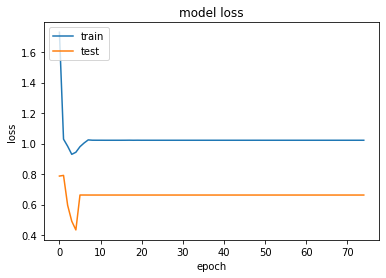

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=75, batch_size=256,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('best_model_embeddings.h5')


In [38]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait


# Create model from word input to output of dense layer right before the attention layer
# print( model.get_layer('time_distributed').output.shape,  len(model.get_layer('dense_final').get_weights()))
hidden_word_encoding_out = Model(inputs=model.input, outputs= model.get_layer('dense').output)
# Load weights from trained attention layer
word_context = model.get_layer('attention').get_weights()
# hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
# ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [39]:
for i in range(0,20):
    #print('data',data[i])
    in_data =data_temp[i].reshape(1,MAX_WORD_NUM)
    y = model.predict(in_data)
    print('result:',y, in_data,train_df.iloc[i].toxicity_sentence)
    print('row:',len(train_df.iloc[i].sentence),train_df.iloc[i].sentence)
    hidden_word_encodings = hidden_word_encoding_out.predict(in_data)
     # Compute context vector using output of dense layer
    ait = wordAttentionWeights(hidden_word_encodings,word_context)
    print('attention',(in_data, ait))

result: [[3.0116553]] [[  68  129    5  151    3    5  875   54   20   65   56 1908   85   10
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 70 because hes a moron and a bigot its not any more complicated than that
attention (array([[  68,  129,    5,  151,    3,    5,  875,   54,   20,   65,   56,
        1908,   85,   10,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   

attention (array([[  29, 1203,   10,  331,   33,   73, 1916,    2, 1917,   61,  331,
         233,   52,    0,   51,   24,   55,   27,   18,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]]), array([0.00885893, 0.00837026, 0.00905837, 0.01040228, 0.00962157,
       0.00966682, 0.01021327, 0.00917712, 0.01138192, 0.00895645,
       0.01038848, 0.009248  , 0.00880145, 0.00919491, 0.00877904,
       0.00922079, 0.00992121, 0.01005553, 0.01106211, 0.01229527,
       0.01223729, 0.01211793, 0.01197

attention (array([[ 418,    5,  332, 1206,   99,    2,  250,    2, 1207, 1922,   11,
         279, 1208,   53,    3, 1923,  131,  487,    4,    2, 1924,  882,
           3,  562,   68,    6,    8,   30,    2,   24,  673, 1209,   10,
         139, 1207,    5,  280,  281,    6,   24,  673, 1209,   11,  152,
           4,  333,    4,  563, 1925,  136,  102,  251,    6, 1926,   13,
          33,  674,   60,    2, 1210,    6,  883,    3, 1927,    0,   27,
         131,  168,  488, 1211,    9, 1928, 1929,   14,    5,   78,  884,
          15,   77,   99,  137,   26,  370,    4,   16, 1212,   60,  168,
           2, 1930,  217,   17,    8, 1213,   15,  310, 1931,  370,    9,
          22]]), array([0.00885399, 0.00925188, 0.00901149, 0.00855728, 0.00946344,
       0.00991878, 0.01076913, 0.01032058, 0.01079061, 0.01054563,
       0.00955247, 0.01005467, 0.01173389, 0.01066171, 0.00920115,
       0.01131653, 0.01131106, 0.01093795, 0.0097437 , 0.00934512,
       0.0086128 , 0.00870922, 0.00824

result: [[2.499625]] [[ 129    5 1967    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 16 hes a psychopath
attention (array([[ 129,    5, 1967,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

attention (array([[  13,  260,   52,  139,    2, 1985, 1986, 1987,    0,  339,    0,
           2,  896,    7,   43,  897, 1988,    3,  499,  169,    0,  898,
          52,    4,   80,   67,    0,    0,    0,    0,    0,    0,    0,
           0,  236,  899,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]]), array([0.00806072, 0.0083971 , 0.00875408, 0.0090856 , 0.00983842,
       0.0108289 , 0.01342085, 0.01269231, 0.01076051, 0.00975456,
       0.00913213, 0.00856181, 0.0087264 , 0.00885384, 0.0094571 ,
       0.00886698, 0.00963494, 0.00798142, 0.0097587 , 0.01106677,
       0.01118143, 0.01165328, 0.00981